The location I chose is Bracebridge, Ontario.

I remove all the data in the dataset if its Provience name is not Ontario.

For the text preprocessing method I implemented to my data, I use tokenization (RegexpTokenizer), lowercasing, removing the stop words, and lemmatization.

In [1]:
# Installing useful libraries
!pip install folium
!pip install tqdm
!pip install numpy
!pip install pandas
!pip install nltk
!pip install scikit-learn
!pip install scipy
!pip install geopy
!pip install tabulate
!pip install textblob
!pip install spacy
!python -m spacy download en_core_web_sm

2023-11-16 08:45:19.705610: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-16 08:45:19.705680: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-16 08:45:19.705721: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-16 08:45:19.714938: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-16 08:45:20.979712: W tensorflow/compiler/

In [2]:
# Importing useful libraries

# Plot
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from wordcloud import WordCloud

# Data Packages
import math
import pandas as pd
import numpy as np

# Progress bar
from tqdm import tqdm

# Counter
from collections import Counter

# Operation
import operator

# Natural Language Processing Packages
import re
import nltk

## Download Resources
nltk.download("vader_lexicon")
nltk.download("stopwords")
nltk.download("averaged_perceptron_tagger")
nltk.download("wordnet")

from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.tag import PerceptronTagger
from nltk.data import find

## Machine Learning
import sklearn
import sklearn.metrics as metrics

## Data Visualization
import folium
from tabulate import tabulate
from scipy.stats.kde import gaussian_kde

## Geolocation
import geopy
from geopy.geocoders import Photon
from geopy.extra.rate_limiter import RateLimiter

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
<ipython-input-2-defc6978454f>:48: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  from scipy.stats.kde import gaussian_kde


In [3]:
# Setting pandas' display
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', 500)

In [4]:
# Use vader to evaluated sentiment of reviews
def evalSentences(sentences, to_df=False, columns=[]):
    # Instantiate an instance to access SentimentIntensityAnalyzer class
    sid = SentimentIntensityAnalyzer()
    pdlist = []
    if to_df:
        for sentence in tqdm(sentences):
            ss = sid.polarity_scores(sentence)
            pdlist.append([sentence]+[ss['compound']])
        reviewDf = pd.DataFrame(pdlist)
        reviewDf.columns = columns
        return reviewDf

    else:
        for sentence in tqdm(sentences):
            print(sentence)
            ss = sid.polarity_scores(sentence)
            for k in sorted(ss):
                print('{0}: {1}, '.format(k, ss[k]), end='')
            print()

In [5]:
# Read in from pandas
columnNames = ['filePath','hotelName','reviewColumn','ratingScore','groundTruth',
               'date_stamp','streetAddress', 'City',
               'Province','postalCode']

hotelDf = pd.read_csv("reviews.csv", header=None, names=columnNames)

In [6]:
# Remove rows where "Provience" is not "Ontario" or is empty
cleaned_hotelDf = hotelDf[(hotelDf["Province"] == "Ontario") & (hotelDf["Province"].notna())]

In [7]:
# Find all the types of data in postalCode column
unique_postal_codes = cleaned_hotelDf["postalCode"].unique()
print(unique_postal_codes)

['P0A 1H0' 'P2A 0B2' 'L0K 1S0' 'L0L 1T0' 'K0M 1M0' 'K0M 1J2' 'P0A 1J0'
 'L0K 2A0' 'P0C 1H0' 'L3V 0S3' 'L9X 1Z7' 'L9Y 0L3']


In [8]:
# Conditions and replacement
replacements = {
    "P0A 1H0": "Dwight",
    "P2A 0B2": "Seguin",
    "L0K 1S0": "Severn",
    "L0L 1T0": "Oro-Medonte",
    "K0M 1M0": "Eagle Lake",
    "K0M 1J2": "Algonquin Highlands",
    "P0A 1J0": "Emsdale",
    "L0K 2A0": "Victoria Harbour",
    "P0C 1H0": "MacTier",
    "L3V 0S3": "Ramara",
    "L9X 1Z7": "Springwater",
    "L9Y 0L3": "Blue Mountains"
}

In [9]:
# Apply replacements
for postal_code, city in replacements.items():
  cleaned_hotelDf.loc[cleaned_hotelDf["postalCode"] == postal_code, "City"] = city

In [10]:
cleaned_hotelDf

filePath                                hotelName                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         reviewColumn  ratingScore groundTruth          date_stamp               streetAddress            City Province postalCode
0      data/ca/1370216/2281359/395404064.html  Spring Lake Resort Motel and Restaurant                                                                                                                                                                                                                                                                                               "A nice short stay in july. Visited Algonquin.  Good meals at the Resort and nearby places.. Very spacious, clean accommodation with pretty views of the small lake. My only complaint is that I had no complaints....            5    positive       July 22, 2016          2893 Hwy 60 Rr # 1          Dwight  Ontario    P0A 1H0
1      data/ca/1370216/2281359/617902954.html  Spring Lake Resort Motel and Restaurant                                                                                          "We didn't stay at the resort but we ate at Spring Lake twice because we enjoyed the food so much the first time. The salads were excellent and chicken vegetable soup with lentils was delicious. The pasta dishes were nicely done. The restaurant was woefully short on serving staff but the woman doing all the hard work was so cheerful about it and worked so hard that we never felt we were waiting for anything.            4    positive  September 19, 2018          2893 Hwy 60 Rr # 1          Dwight  Ontario    P0A 1H0
2      data/ca/1370216/2281359/487031951.html  Spring Lake Resort Motel and Restaurant                                                                                                                                                                                                                                                                                          "Comfortable rooms, friendly and helpful staff. Lots to do in the immediate area and then a great place to return to and have a great meal. Excellent breakfast. The forests and waterways encourage you to be adventurous.            4    positive        May 23, 2017          2893 Hwy 60 Rr # 1          Dwight  Ontario    P0A 1H0
3      data/ca/1370216/2281359/590061454.html  Spring Lake Resort Motel and Restaurant  "Had a really positive experience here. Fairly quiet here and the vibe is quaint. The view to the lake is just what you need. You can even go on a short sail with a canoe. I was looking for a place with an option to eat both breakfast and dinner in case nothing else would be near by - so Spring Lake resort was one of the very few resorts with an actual restaurant.\n\nWe got a room at the upper level.\nRoom was clean and tidy and overall I would totally recommend.\n\nThe restaurant offers ver...            4    positive       June 23, 2018          2893 Hwy 60 Rr # 1          Dwight  Ontario    P0A 1H0
4      data/ca/1370216/2281359/336281499.html  Spring Lake Resort Motel and Restaurant  "We stayed for 3 nights in the middle of October. The owners were gracious, friendly and accommodating.\n\nThe property is a gem. The hotel is situated next to a small lake surrounded by trees and the area in between the hotel and the lake is beautifully landscaped. The view from the balcony was lovely, especially considering the fall colours. There are walking trails around the lake in the woods and plenty of free parking. \n\nThe restaurant was closed for th

In [11]:
reviews = cleaned_hotelDf['reviewColumn'].values

In [12]:
reviewDF = evalSentences(reviews, to_df=True, columns=['reviewCol','vader'])

100%|██████████| 1178/1178 [00:01<00:00, 714.14it/s]


In [13]:
reviewDF

reviewCol   vader
0                                                                                                                                                                                                                                                                                                  "A nice short stay in july. Visited Algonquin.  Good meals at the Resort and nearby places.. Very spacious, clean accommodation with pretty views of the small lake. My only complaint is that I had no complaints....  0.8166
1                                                                                             "We didn't stay at the resort but we ate at Spring Lake twice because we enjoyed the food so much the first time. The salads were excellent and chicken vegetable soup with lentils was delicious. The pasta dishes were nicely done. The restaurant was woefully short on serving staff but the woman doing all the hard work was so cheerful about it and worked so hard that we never felt we were waiting for anything.  0.9715
2                                                                                                                                                                                                                                                                                             "Comfortable rooms, friendly and helpful staff. Lots to do in the immediate area and then a great place to return to and have a great meal. Excellent breakfast. The forests and waterways encourage you to be adventurous.  0.9796
3     "Had a really positive experience here. Fairly quiet here and the vibe is quaint. The view to the lake is just what you need. You can even go on a short sail with a canoe. I was looking for a place with an option to eat both breakfast and dinner in case nothing else would be near by - so Spring Lake resort was one of the very few resorts with an actual restaurant.\n\nWe got a room at the upper level.\nRoom was clean and tidy and overall I would totally recommend.\n\nThe restaurant offers ver...  0.9789
4     "We stayed for 3 nights in the middle of October. The owners were gracious, friendly and accommodating.\n\nThe property is a gem. The hotel is situated next to a small lake surrounded by trees and the area in between the hotel and the lake is beautifully landscaped. The view from the balcony was lovely, especially considering the fall colours. There are walking trails around the lake in the woods and plenty of free parking. \n\nThe restaurant was closed for the season and the owners notified...  0.9343
...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   ...     ...
1173  "We have stayed at Blue View multiple times over the past 10 years, for various group holidays and weekends away.  \n\nThe chalets are clean, warm and inviting, and perfect for groups or families. They are well equipped with kitchen supplies, etc.  The hot tub is also great! \n\nLocation is excellent and we have enjoyed the chalets in both summer and winter. \n\nManagement is very easy to deal with and clearly cares and maintains the property very well. \n\nTo summarize - Thumbs up, highly r...  0.9907
1174                                                                                                                                                                                                                                                                                                       "Beautiful accommodations, very spacious, with awesome views.  I was here for a weeke

In [14]:
# Import the packages
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer


# Function to get a comprehensive list of stop words
def get_stop_words():
    stop = set(stopwords.words('english'))
    # Add possible stop words for hotel reviews
    stop.update(['hotel', 'room', 'rooms', 'stay', 'staff'])
    return stop

# Function to get top K words from the reviews
def getTopKWords(df, kwords):
    stop = get_stop_words()
    counter = Counter()
    tokenizer = RegexpTokenizer(r'\w+')
    lemmatizer = WordNetLemmatizer()

    reviews = df['reviewCol'].values

    for review in reviews:
        words = tokenizer.tokenize(review)
        counter.update([lemmatizer.lemmatize(word.lower())
                        for word in words
                        if word.lower() not in stop and len(word) > 2])

    topk = counter.most_common(kwords)
    return topk

# Function to transform the DataFrame
def dataFrameTransformation(hotelDf, reviewDF, topk):
    tokenizer = RegexpTokenizer(r'\w+')
    lemmatizer = WordNetLemmatizer()
    reviews = reviewDF['reviewCol'].values

    # Find out if a particular review has the word from topk list
    freqReview = []
    for review in reviews:
        words = tokenizer.tokenize(review)
        tempCounter = Counter([lemmatizer.lemmatize(word.lower()) for word in words])
        topkinReview = [1 if tempCounter[word] > 0 else 0 for (word, wordCount) in topk]
        freqReview.append(topkinReview)

    # Prepare freqReviewDf
    freqReviewDf = pd.DataFrame(freqReview)
    dfName = [c[0] for c in topk]
    freqReviewDf.columns = dfName
    finalreviewDf = reviewDF.join(freqReviewDf)
    finaldf = hotelDf[['hotelName', 'ratingScore', 'groundTruth']].join(finalreviewDf)
    return finaldf

In [15]:
topk = getTopKWords(reviewDF, 500)
finaldf = dataFrameTransformation(cleaned_hotelDf, reviewDF, topk)
cleaned_finaldf = finaldf.dropna()

In [16]:
cleaned_finaldf

hotelName  ratingScore groundTruth                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            reviewCol   vader  great  clean  resort  place  time  would  lake  night  day  well  back  cottage  nice  stayed  one  family  area  breakfast  good  friendly  park  food  also  year  comfortable  lot  nthe  water  bed  beautiful  cabin  view  really  kid  get  like  wonderful  could  pool  owner  need  algonquin  everything  enjoyed  restaurant  even  weekend  recommend  service  use  next  small  experience  two  inn  location  make  fire  definitely  host  nwe  lovely  amazing  helpful  dinner  guest  little  away  much  perfect  boat  thing  u2019t  property  many  close  beach  excellent  made  every  people  harry  site  u2019s  carol  trail  always  visit  first  right  best  hot  home  feel  loved  spa  way  meal  come  around  couple  booked  went  free  activity  canoe  want  minute  trip  enjoy  return  see  tub  highly  price  needed  lodge  quiet  summer  looking  found  ground  week  drive  table  wood  check  evening  bathroom  large  front  friend  motel  fun  better  say  spent  kitchen  chair  going  dining  getaway  available  delicious  enough  another  know  love  outside  amenity  sure  blue  never  got  new  relaxing  fantastic  coffee  warm  morning  take  last  husband  staying  fireplace  bit  door  old  accommodation  paddle  hour  kayak  main  however  child  pit  able  big  severn  offer  fall  kept  maintained  walk  spot  spacious  game  store  thank  full  country  quite  review  keep  find  ever  long  desk  fridge  winter  bbq  provided  suite  cozy  arrived  heather  absolutely  vacation  still  dock  spruce  felt  especially  road  told  look  covid  coming  size  welcoming  koa  super  etc  second  extremely  took  adult  although  think  top  book  jackie  overall  short  plenty  though  extra  everyone  bedroom  wife  facility  wait  forward  towel  group  easy  outdoor  shower  located  loralea  casino  work  came  quality  something  since  issue  relax  dog  offered  rawley  sam  bring  huntsville  run  awesome  special  part  left  chalet  nothing  bad  equipped  put  tucked  menu  three  space  thanks  eat  end  anyone  open  booking  care  accommodating  fresh  asked  welcome  bill  sir  help  muskoka  private  problem  unit  near  included  used  fishing  jim  done  option  kind  already  local  wanted  weather  sunnylea  set  fabulous  side  happy  star  whole  pleasant  reservation  due  within  making  anything  without  microwave  lunch  across  leave  disappointed  far  life  swimming  huge  hope  may  show  harbour  choice  said  several  board  give  pretty  parking  looked  plan  along  enjoyable  different  oxtongue  pizza  manager  nearby  customer  ontario  building  rama  balcony  comfy  stop  hiking  gorgeous  soon  setting  decided  house  spend  busy  early  spotless  window  young  rate  try  sleep  visited  hard  walking  floor  wifi  play  snow  ice  rustic  must  eagle  high  recommended  nthis  ask  working  deck  air  thought  ski  barrie  season  wine  distance  worth  nature  let  called  dwight  course  bar  campground  ride  dish  impressed  u201d  sit  nthere  ready  camp  expectation  hill  plus  west  gate  inside  city  given  returning  point  maybe  call  past  tell  stocked  dated  wish  glen  spring  gem  charge  highway  reasonable  cold  furniture  sitting  fern  money  expect  certainly  access  bike  atmosphere  noise  order  beyond  visiting  loud  shirley  else  standard  closed  drink  fine  min  basic  cleanliness  recently  

In [17]:
# Calculate average Vader sentiment per hotel
avg_vader_scores = cleaned_finaldf.groupby("hotelName")["vader"].mean().reset_index()
avg_vader_scores

hotelName     vader
0                        Blue Spruce Resort  0.917451
1           Christie&#39;s Mill Inn and Spa  0.963300
2                      Dwight Village Motel  0.902852
3                     Fern Glen Inn B&amp;B  0.773811
4                    Heidi&#39;s Campground  0.770411
5                  Lakewoods Cottage Resort  0.812961
6                       Logging Chain Lodge  0.948700
7                Loralea Country Inn Resort  0.727149
8                Muskoka Waterfront Retreat  0.941300
9                             Rawley Resort  0.729826
10                             Severn Lodge  0.811696
11                    Silver Eagle Cottages  0.977994
12              Sir Sam&#39;s Inn &amp; Spa  0.966692
13  Spring Lake Resort Motel and Restaurant  0.845339
14                Sun Retreats Georgian Bay  0.728825
15                          Sunnylea Resort  0.646632
16                 The Pines Cottage Resort  0.894385

In [18]:
# Calculate the average ground truth rating per hotel
avg_rating_scores = cleaned_finaldf.groupby("hotelName")["ratingScore"].mean().reset_index()
avg_rating_scores

hotelName  ratingScore
0                        Blue Spruce Resort     4.820000
1           Christie&#39;s Mill Inn and Spa     3.315789
2                      Dwight Village Motel     4.641791
3                     Fern Glen Inn B&amp;B     4.964286
4                    Heidi&#39;s Campground     2.888889
5                  Lakewoods Cottage Resort     4.483871
6                       Logging Chain Lodge     4.833333
7                Loralea Country Inn Resort     4.791045
8                Muskoka Waterfront Retreat     5.000000
9                             Rawley Resort     4.450000
10                             Severn Lodge     4.240000
11                    Silver Eagle Cottages     4.705882
12              Sir Sam&#39;s Inn &amp; Spa     3.550000
13  Spring Lake Resort Motel and Restaurant     4.390000
14                Sun Retreats Georgian Bay     3.750000
15                          Sunnylea Resort     4.025641
16                 The Pines Cottage Resort     4.538462

In [19]:
# Calculate median Vader sentiment per hotel
median_vader_scores = cleaned_finaldf.groupby("hotelName")["vader"].median().reset_index()
median_vader_scores

hotelName    vader
0                        Blue Spruce Resort  0.96710
1           Christie&#39;s Mill Inn and Spa  0.97850
2                      Dwight Village Motel  0.95790
3                     Fern Glen Inn B&amp;B  0.95445
4                    Heidi&#39;s Campground  0.99000
5                  Lakewoods Cottage Resort  0.94740
6                       Logging Chain Lodge  0.96600
7                Loralea Country Inn Resort  0.94590
8                Muskoka Waterfront Retreat  0.94130
9                             Rawley Resort  0.96255
10                             Severn Lodge  0.97320
11                    Silver Eagle Cottages  0.98200
12              Sir Sam&#39;s Inn &amp; Spa  0.98480
13  Spring Lake Resort Motel and Restaurant  0.95840
14                Sun Retreats Georgian Bay  0.93610
15                          Sunnylea Resort  0.97135
16                 The Pines Cottage Resort  0.97710

In [20]:
# Rank by Average Ground Truth Sentiment
avg_rating_rank = avg_rating_scores.sort_values(by="ratingScore", ascending=False)

# Rank by Average Vader Compound Sentiment Score
avg_vader_rank = avg_vader_scores.sort_values(by="vader", ascending=False)

# Rank by Median Vader Compound Sentiment Score
median_vader_rank = median_vader_scores.sort_values(by="vader", ascending=False)

In [21]:
# Function to display top-5 and bottom-5 for each ranking
def display_rankings(df, ranking_type):
    print(f"\nTop-5 Hotels by {ranking_type}:\n", df.head(5))
    print(f"\nBottom-5 Hotels by {ranking_type}:\n", df.tail(5))

# Display the rankings
display_rankings(avg_rating_rank , "Average Rating Score")
display_rankings(avg_vader_rank, "Average Vader Compound Sentiment Score")
display_rankings(median_vader_rank, "Median Vader Compound Sentiment Score")


Top-5 Hotels by Average Rating Score:
                     hotelName  ratingScore
8  Muskoka Waterfront Retreat     5.000000
3       Fern Glen Inn B&amp;B     4.964286
6         Logging Chain Lodge     4.833333
0          Blue Spruce Resort     4.820000
7  Loralea Country Inn Resort     4.791045

Bottom-5 Hotels by Average Rating Score:
                           hotelName  ratingScore
15                  Sunnylea Resort     4.025641
14        Sun Retreats Georgian Bay     3.750000
12      Sir Sam&#39;s Inn &amp; Spa     3.550000
1   Christie&#39;s Mill Inn and Spa     3.315789
4            Heidi&#39;s Campground     2.888889

Top-5 Hotels by Average Vader Compound Sentiment Score:
                           hotelName     vader
11            Silver Eagle Cottages  0.977994
12      Sir Sam&#39;s Inn &amp; Spa  0.966692
1   Christie&#39;s Mill Inn and Spa  0.963300
6               Logging Chain Lodge  0.948700
8        Muskoka Waterfront Retreat  0.941300

Bottom-5 Hotels by Average Vad

The results from my output above do not agree with each other. While there's some agreement, particularly in the top rankings (e.g., "Muskoka Waterfront Retreat" ranks high in both average rating and average Vader score), notable differences emerge. For instance, "Sir Sam's Inn & Spa" and "Christie's Mill Inn and Spa" appear in the bottom-5 for average rating yet are top-ranked in Vader sentiment scores. This suggests a mismatch between the sentiment expressed in review texts and the numerical ratings; the text may convey positive sentiments not reflected in the numerical score. Furthermore, the difference between the average and median Vader scores, especially in the lower rankings, points to the influence of outliers in sentiment analysis. While the average is sensitive to extreme sentiment values, the median provides a central tendency less affected by such extremes. This discrepancy highlights the nuanced nature of guest experiences and reviews, where the subjective nature of numerical ratings and the qualitative aspects of review texts must be considered together for a comprehensive understanding of hotel performance and guest satisfaction.

In [22]:
# Setting default parameters of WordCloud object
wordcloud_args = dict(
    width = 800,
    height = 800,
    background_color ='white',
    min_font_size = 10
    )

# Fucntion to plot word cloud
def plotWordCloud(dictionary, **kwargs):
    wordcloud = WordCloud(**kwargs)

    wordcloud.generate_from_frequencies(dict(dictionary))
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [23]:
# Seperate positive and negative reviews
positive_reviews = cleaned_finaldf[cleaned_finaldf["groundTruth"] == "positive"]["reviewCol"]
negative_reviews = cleaned_finaldf[cleaned_finaldf["groundTruth"] == "negative"]["reviewCol"]

In [24]:
# Modified version of the getTopKWords
def get_top_words(series, kwords):
    stop = get_stop_words()
    counter = Counter()
    tokenizer = RegexpTokenizer(r'\w+')
    lemmatizer = WordNetLemmatizer()

    for review in series:
        words = tokenizer.tokenize(review)
        counter.update([lemmatizer.lemmatize(word.lower())
                        for word in words
                        if word.lower() not in stop and len(word) > 2])

    topk = counter.most_common(kwords)
    return topk

In [25]:
# Find the top-50 words for both categories
top_50_positive = get_top_words(positive_reviews, 50)
top_50_negative = get_top_words(negative_reviews, 50)

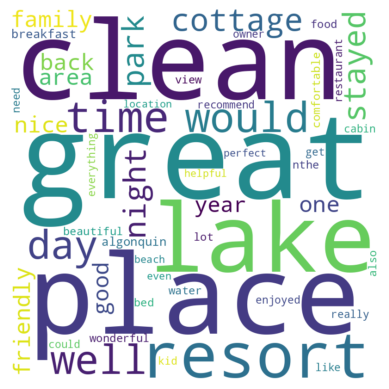

In [26]:
# Generate word cloud for positive reviews
plotWordCloud(dict(top_50_positive), **wordcloud_args)

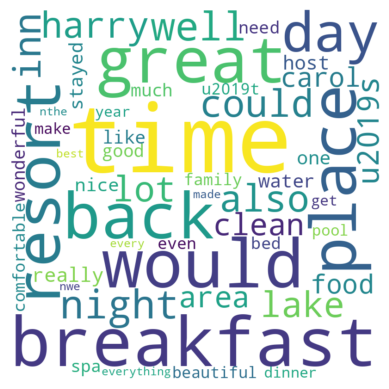

In [27]:
# Generate word cloud for negative reviews
plotWordCloud(dict(top_50_negative), **wordcloud_args)

From the outputs above, I see that words like "lake," "resort," "beach," and "park" are likely to be location-specific, referring to the features or amenities associated with the hotel or its surroundings. "Algonquin" could be a reference to Algonquin Provincial Park in Ontario, Canada, suggesting that these reviews are related to hotels or resorts near or within this area.

Common words that appear in both positive and negative reviews include "great," "time," "resort," "breakfast," "back," "clean," and "lake." These words are generally positive in nature and suggest that guests have strong opinions about these aspects of their stay, regardless of the overall sentiment of the review.

It's interesting to see "clean" appear in both positive and negative reviews. Typically, cleanliness is associated with positive experiences, so its presence in negative reviews could indicate specific concerns or expectations not being met, even if the overall cleanliness was good. Also, the word "back" is also present in both, which in positive reviews might suggest a desire to return, while in negative contexts could be part of phrases relating to complaints or issues that guests want to be addressed.

In [28]:
# Import the package
from nltk import RegexpParser
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('wordnet')


# Define the grammar for noun phrases
grammar = r"""
    NBAR:
        {<NN.*|JJ>*<NN.*>}  # Nouns and Adjectives, terminated with Nouns
    NP:
        {<NBAR><IN><NBAR>}  # Above, connected with in/of/etc...
        {<NBAR>}  # Above, standalone
"""

# Create the chunk parser
chunker = RegexpParser(grammar)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [29]:
# Function to extract noun phrases
def extract_np(tagged_sentences, chunker):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words("english"))
    custom_stop_words = ["hotel", "room", "rooms", "stay", "staff", "b", "park", "tub"]
    stop_words.update(custom_stop_words)
    all_noun_phrases = []
    for sent in tagged_sentences:
        tree = chunker.parse(sent)
        for subtree in tree.subtrees():
            if subtree.label() == "NP":
                # Lemmatize, lowercase and filter out stop words and 'b'
                filtered_phrase = [
                    lemmatizer.lemmatize(word.lower(), pos="n" if tag.startswith("NN") else "a")
                    for word, tag in subtree.leaves()
                    if word.lower() not in stop_words and not word.lower().startswith("b") and tag.startswith(("NN", "JJ"))
                ]
                if filtered_phrase:
                    np = " ".join(filtered_phrase)
                    all_noun_phrases.append(np)
    return all_noun_phrases

In [30]:
# Tokenize and POS tag the sentences in the reviews
def tokenize_and_tag(reviews):
    sentences = [nltk.sent_tokenize(review) for review in reviews]
    sentences = [item for sublist in sentences for item in sublist]
    tokenized_sentences = [nltk.word_tokenize(sentence) for sentence in sentences]
    tagged_sentences = [nltk.pos_tag(sentence) for sentence in tokenized_sentences]
    return tagged_sentences

In [31]:
# Get the tagged sentences for positive and negative reviews
tagged_positive = tokenize_and_tag(positive_reviews)
tagged_negative = tokenize_and_tag(negative_reviews)

# Extract noun phrases from the tagged sentences
np_positive = extract_np(tagged_positive, chunker)
np_negative = extract_np(tagged_negative, chunker)

# Get the top-50 noun phrases for both categories
top_50_np_positive = Counter(np_positive).most_common(50)
top_50_np_negative = Counter(np_negative).most_common(50)

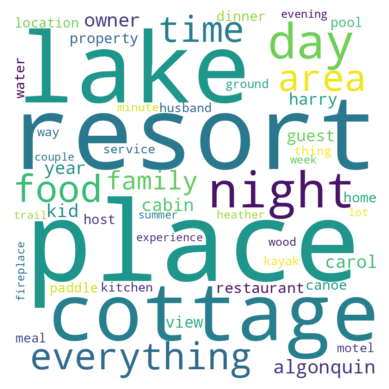

In [32]:
# Generate word cloud for positive reviews
plotWordCloud(dict(top_50_np_positive), **wordcloud_args)

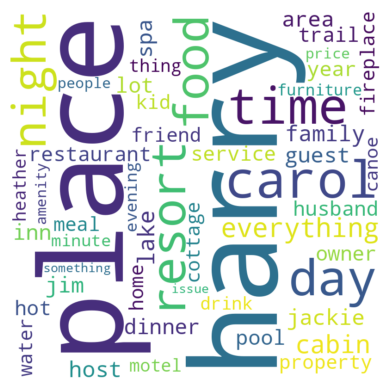

In [33]:
# Generate word cloud for negative reviews
plotWordCloud(dict(top_50_np_negative), **wordcloud_args)

From the outputs above, we can see that both positive and negative reviews mention central aspects like "place," "food," "cottage," "resort," "lake," and "day." These phrases are fundamental components of a typical hotel or resort experience and are therefore likely to be mentioned regardless of sentiment.

The noun phrase "issue" appearing in the positive reviews could be unexpected. It typically has a negative connotation. However, it may appear in positive reviews within a context that suggests resolution or minor impact, such as "minor issue but resolved quickly," indicating that the overall experience was still positive.

In [34]:
# Define a new grammar pattern
new_grammar = r"""
    ANBAR:
        {<JJ><NN.*>}  # Adjective followed by a noun
"""

# Update the chunk parser with the new grammar
new_chunker = RegexpParser(new_grammar)

In [35]:
# Function to extract phrases using the new grammar
def extract_an_phrases(tagged_sentences, chunker):
    all_phrases = []
    for sent in tagged_sentences:
        tree = chunker.parse(sent)
        for subtree in tree.subtrees():
            if subtree.label() == "ANBAR":
                # Join the phrase words into a single string
                an_phrase = " ".join(word for word, tag in subtree.leaves())
                all_phrases.append(an_phrase)
    return all_phrases

In [36]:
# Use the updated functions to extract AN phrases
an_positive = extract_an_phrases(tagged_positive, new_chunker)
an_negative = extract_an_phrases(tagged_negative, new_chunker)

# Get the top phrases for both categories
top_an_positive = Counter(an_positive).most_common(50)
top_an_negative = Counter(an_negative).most_common(50)

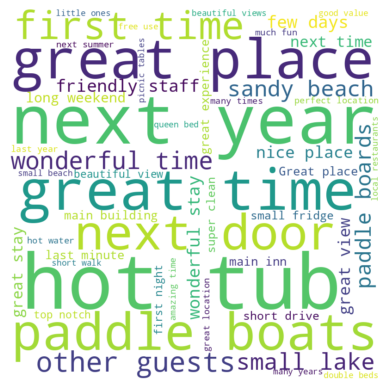

In [37]:
# Generate word cloud for positive reviews
plotWordCloud(dict(top_an_positive), **wordcloud_args)

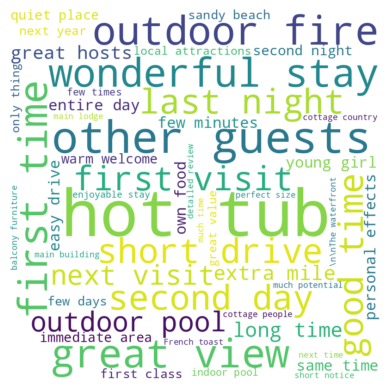

In [38]:
# Generate word cloud for negative reviews
plotWordCloud(dict(top_an_negative), **wordcloud_args)

From the outputs above, we can see that there exist differences between the noun phrases in Q2(b) and Q2(c). Firstly, we can see that there exist common themes across sentiments in Q2(c). Certain themes, like time-related phrases ("next year," "first time," "long time"), and terms denoting location and amenities ("outdoor fire," "sandy beach), appear across both positive and negative reviews. This indicates that these aspects are crucial to the guest experience, regardless of sentiment. Secondly, the positive reviews from Q2(c) include phrases like "wonderful time" and "friendly staff," which directly convey positive sentiment. In contrast, phrases such as "hot tub" and "paddle boats" are more neutral and could be associated with both positive and negative experiences depending on context. Lastly, Q2(c) seems to have extracted phrases that offer more detailed insights into guest experiences, such as "sandy beach" and "short walk," compared to the broader terms from Q2(b) like "food" and "day." This level of detail can be valuable in pinpointing specific aspects of the guest experience that may need attention

The adjective-noun grammar pattern deployed in Q2(c) proves potentially more effective for sentiment analysis, primarily due to its descriptive quality. This pattern, focusing on adjective-noun pairs, tends to elicit clearer sentiment indicators, as adjectives provide qualifying context to the nouns, sharpening the sentiment expressed (whether positive or negative). Such contextual relevance is crucial as it enhances the specificity of the guests' experiences captured in the reviews, making sentiments more explicit and easier to classify. Moreover, the targeted insights gained from this pattern are particularly valuable for businesses, as they pinpoint precisely what aspects guests perceive positively or negatively, offering actionable intelligence for service improvements or maintenance. While both the noun phrase and adjective-noun phrase patterns offer valuable insights, the direct sentiment linkage inherent in the adjective-noun combinations of Q2(c) renders them especially conducive for nuanced sentiment analysis.

In [39]:
# Get Top K mutual information terms from the dataframe
def getMI(topk, df, label_column='groundTruth'):
    miScore = []
    for word in topk:
        miScore.append([word[0]]+[metrics.mutual_info_score(df[label_column], df[word[0]])])
    miScoredf = pd.DataFrame(miScore).sort_values(1,ascending=0)
    miScoredf.columns = ['Word','MI Score']
    return miScoredf

In [40]:
# Calculate MI score for positive reviews
miScoredf_pos = getMI(top_50_positive, cleaned_finaldf)
miScoredf_pos

Word      MI Score
21    algonquin  1.746598e-02
22    breakfast  1.234206e-02
12         park  1.011729e-02
45      helpful  8.365764e-03
17     friendly  4.674425e-03
3          lake  4.109281e-03
40        could  3.908279e-03
48        beach  3.898022e-03
2         clean  3.625734e-03
15         back  3.340443e-03
36         like  2.907859e-03
9       cottage  2.753639e-03
37          kid  2.418696e-03
46     location  2.110323e-03
42        owner  2.062430e-03
5          time  2.049158e-03
49      perfect  1.970272e-03
29        water  1.565922e-03
47         even  1.536899e-03
20         year  1.432023e-03
13       family  1.289626e-03
26         view  1.234801e-03
10       stayed  1.197659e-03
25         food  1.070751e-03
32    wonderful  1.038594e-03
1         place  9.917655e-04
41    recommend  9.613218e-04
19         good  9.152263e-04
0         great  8.273354e-04
33       really  7.208564e-04
24         also  6.112899e-04
23  comfortable  5.560111e-04
44      enjoyed  4.428582e-04
31          lot  4.064617e-04
8           day  2.248196e-04
4        resort  1.881205e-04
39         need  1.575253e-04
18         nice  1.303070e-04
30          bed  1.142637e-04
28         nthe  1.127109e-04
11        night  7.710405e-05
43   restaurant  5.071299e-05
27    beautiful  3.774317e-05
34          get  2.185269e-05
38        cabin  1.794925e-05
16         area  1.553631e-05
14          one  9.322637e-06
7          well  5.229879e-07
35   everything  3.079629e-07
6         would  7.125058e-08

In [41]:
# Calculate MI score for positive reviews
miScoredf_neg = getMI(top_50_negative, cleaned_finaldf)
miScoredf_neg

Word      MI Score
1     breakfast  1.234206e-02
13        harry  1.112388e-02
19        carol  1.056734e-02
11          inn  7.058207e-03
22         host  6.413912e-03
14         lake  4.109281e-03
10        could  3.908279e-03
16        clean  3.625734e-03
5          back  3.340443e-03
17       u2019s  3.120407e-03
49         best  3.006474e-03
27         like  2.907859e-03
39         make  2.145901e-03
0          time  2.049158e-03
48         made  2.039788e-03
25        water  1.565922e-03
28         much  1.536899e-03
35         even  1.536899e-03
43         year  1.432023e-03
32          spa  1.384247e-03
37       family  1.289626e-03
24       stayed  1.197659e-03
20         food  1.070751e-03
30    wonderful  1.038594e-03
4         place  9.917655e-04
36       u2019t  9.434019e-04
29         good  9.152263e-04
3         great  8.273354e-04
21       really  7.208564e-04
12         also  6.112899e-04
41       dinner  5.910414e-04
34  comfortable  5.560111e-04
46        every  4.345000e-04
15          lot  4.064617e-04
7           day  2.248196e-04
6        resort  1.881205e-04
45          nwe  1.751230e-04
31         need  1.575253e-04
26         nice  1.303070e-04
33          bed  1.142637e-04
47         nthe  1.127109e-04
8         night  7.710405e-05
40         pool  6.570954e-05
38    beautiful  3.774317e-05
42          get  2.185269e-05
18         area  1.553631e-05
23          one  9.322637e-06
9          well  5.229879e-07
44   everything  3.079629e-07
2         would  7.125058e-08

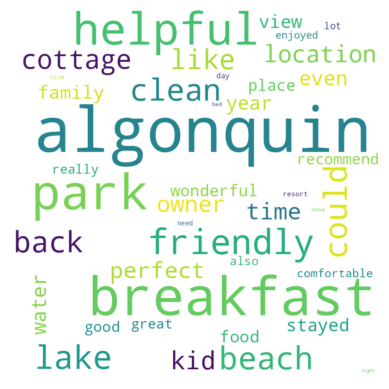

In [42]:
# Generate the word cloud for positive reviews
plotWordCloud(dict(zip(miScoredf_pos["Word"], miScoredf_pos["MI Score"])), **wordcloud_args)

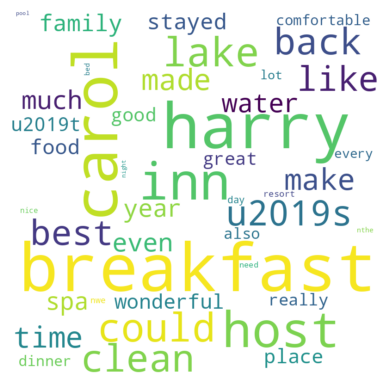

In [43]:
# Generate the word cloud for negative reviews
plotWordCloud(dict(zip(miScoredf_neg["Word"], miScoredf_neg["MI Score"])), **wordcloud_args)

From the output above, the word "algonquin" gets the highest MI value which is 0.01746598 for positive reviews and the word "breakfast" gets the highest MI value which is 0.01234206 for negative reviews.

Yes, it does make sense. Firstly, for the positive reviews, we can see that the word "algonquin" has the largest size in the picture of the word cloud which matches the MI value. Also, for the negative reviews, we can see that the word "breakfast" has the largest size in the picture of the word cloud which matches the MI value. And then, since our selected location is near the Algonquin, it is very common that the positive reviews include "algonquin". Also, it is very common that the negative reviews include "breakfast" when people want to complain about the breakfast.

In [44]:
# Calculate MI score for positive reviews
miScoredf_pos_np = getMI(top_50_np_positive, cleaned_finaldf)
miScoredf_pos_np

Word      MI Score
11   algonquin  1.746598e-02
18       harry  1.112388e-02
14       carol  1.056734e-02
26        host  6.413912e-03
2         lake  4.109281e-03
36     kitchen  3.048913e-03
3      cottage  2.753639e-03
13         kid  2.418696e-03
27    location  2.110323e-03
12       owner  2.062430e-03
9         time  2.049158e-03
31       motel  1.769865e-03
37       kayak  1.769865e-03
22       water  1.565922e-03
15        year  1.432023e-03
41     heather  1.421788e-03
33     husband  1.421412e-03
49   fireplace  1.421412e-03
17       guest  1.374786e-03
10      family  1.289626e-03
19        view  1.234801e-03
7         food  1.070751e-03
0        place  9.917655e-04
42      couple  8.819866e-04
29      paddle  8.452794e-04
38      ground  7.754302e-04
21    property  6.384766e-04
23      dinner  5.910414e-04
48        week  5.591427e-04
45     evening  5.189304e-04
32         way  5.076119e-04
44       trail  4.413666e-04
46  experience  4.345000e-04
43         lot  4.064617e-04
24       canoe  3.451874e-04
40      minute  3.419893e-04
5          day  2.248196e-04
34     service  1.985729e-04
1       resort  1.881205e-04
30        meal  8.605016e-05
4        night  7.710405e-05
35       thing  6.582651e-05
28        pool  6.570954e-05
20  restaurant  5.071299e-05
25        home  2.958692e-05
16       cabin  1.794925e-05
8         area  1.553631e-05
39        wood  9.945632e-06
47      summer  9.945632e-06
6   everything  3.079629e-07

In [45]:
# Calculate MI score for negative reviews
miScoredf_neg_np = getMI(top_50_np_negative, cleaned_finaldf)
miScoredf_neg_np

Word      MI Score
0        harry  1.112388e-02
2        carol  1.056734e-02
38       drink  9.746231e-03
16         inn  7.058207e-03
12        host  6.413912e-03
17         jim  5.464145e-03
18      jackie  4.505645e-03
10        lake  4.109281e-03
32     cottage  2.753639e-03
49       issue  2.447605e-03
33         kid  2.418696e-03
44   furniture  2.205604e-03
23       owner  2.062430e-03
3         time  2.049158e-03
40       motel  1.769865e-03
30      friend  1.648747e-03
31       water  1.565922e-03
21        year  1.432023e-03
41     heather  1.421788e-03
27     husband  1.421412e-03
35   fireplace  1.421412e-03
15         spa  1.384247e-03
13       guest  1.374786e-03
11      family  1.289626e-03
6         food  1.070751e-03
45      people  1.007405e-03
1        place  9.917655e-04
46     amenity  6.914388e-04
34    property  6.384766e-04
19      dinner  5.910414e-04
48   something  5.543220e-04
43     evening  5.189304e-04
26         hot  4.913501e-04
28       trail  4.413666e-04
20         lot  4.064617e-04
37       canoe  3.451874e-04
42      minute  3.419893e-04
4          day  2.248196e-04
24     service  1.985729e-04
5       resort  1.881205e-04
47       price  1.234655e-04
29        meal  8.605016e-05
7        night  7.710405e-05
39       thing  6.582651e-05
22        pool  6.570954e-05
25  restaurant  5.071299e-05
36        home  2.958692e-05
9        cabin  1.794925e-05
14        area  1.553631e-05
8   everything  3.079629e-07

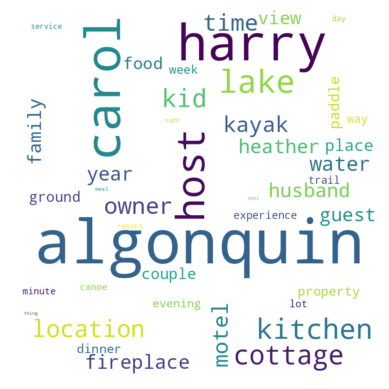

In [46]:
# Generate the word cloud for positive reviews
plotWordCloud(dict(zip(miScoredf_pos_np["Word"], miScoredf_pos_np["MI Score"])), **wordcloud_args)

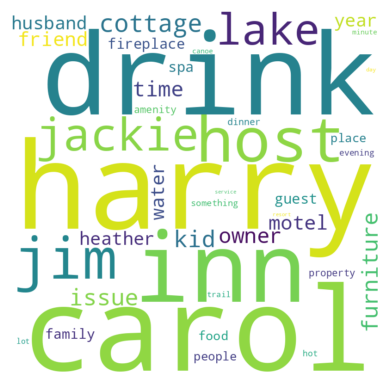

In [47]:
# Generate the word cloud for negative reviews
plotWordCloud(dict(zip(miScoredf_neg_np["Word"], miScoredf_neg_np["MI Score"])), **wordcloud_args)

From the output above, the word "algonquin" gets the highest MI value which is 0.01746598 for positive reviews and the word "harry" gets the highest MI value which is 0.01112388 for negative reviews.

Firstly, personalized service is paramount, as the mention of staff names in both positive and negative reviews underscores the impact of personal interactions on guest satisfaction; therefore, investing in training for staff to provide consistent, high-quality service is essential. Secondly, upkeep and modernization of facilities and amenities, particularly "fireplace" and "furniture," should be prioritized to meet guests' expectations, alongside enhancing the functionality of "kitchens" and the comfort of "cottages". Lastly, given the prominence of "lake" in guest feedback, augmenting lake-related activities, ensuring their cleanliness, and offering amenities such as "kayaks" would likely convert negative perceptions into positive ones.

In [48]:
# Compute PMI for all terms and all possible labels
def pmiForAllCal(df, topk_word, gt_sentiment, label_column='groundTruth'):
    #Try calculate all the pmi for top k and store them into one pmidf dataframe

    index = [x[0] for x in topk_word]
    pmiDf = pd.DataFrame(index=index, columns=['pmi'])

    for (word, count) in tqdm(topk_word):
        pmiDf.at[word, 'pmi'] = pmiCalc(df,word,gt_sentiment,label_column)

    return pmiDf


def pmiCalc(df, word, gt_sentiment, label_column='groundTruth'):

    N = df.shape[0]

    px = sum(df[label_column]==gt_sentiment)
    py = sum(df[word]==True)
    pxy = len(df[(df[label_column]==gt_sentiment) & (df[word]==True)])
    px = max(px, 0.0001)
    py = max(py, 0.0001)

    if pxy==0:#Log 0 cannot happen
        pmi = math.log((pxy+0.0001)*N/(px*py))
    else:
        pmi = math.log(pxy*N/(px*py))
    return pmi

In [49]:
# Calculate the top-50 words according to PMI for positive reviews
pmiposdf_pos = pmiForAllCal(cleaned_finaldf, top_50_positive, "positive").sort_values("pmi", ascending=0)

100%|██████████| 50/50 [00:00<00:00, 617.13it/s]


In [50]:
pmiposdf_pos

pmi
algonquin    0.133928
helpful      0.113855
park         0.100653
beach        0.087408
kid          0.078674
cottage      0.066614
perfect      0.065286
friendly     0.064766
location     0.062548
owner        0.060162
lake         0.052725
year         0.045709
clean        0.042444
view         0.041029
recommend    0.039968
family       0.039026
good         0.033844
stayed       0.031214
enjoyed      0.028789
place         0.02603
comfortable  0.025065
great        0.021226
need         0.018096
nthe         0.015495
resort       0.014698
nice         0.012901
restaurant   0.010314
night        0.008584
cabin        0.007127
get          0.006321
area         0.004436
would       -0.000253
well        -0.000699
everything  -0.000699
one         -0.003487
beautiful   -0.007285
bed         -0.013919
day          -0.01521
lot         -0.025779
also        -0.031679
food        -0.039202
really      -0.041663
time        -0.041875
wonderful   -0.045199
water       -0.055122
back        -0.059664
even        -0.063969
like          -0.0797
could       -0.094833
breakfast   -0.125277

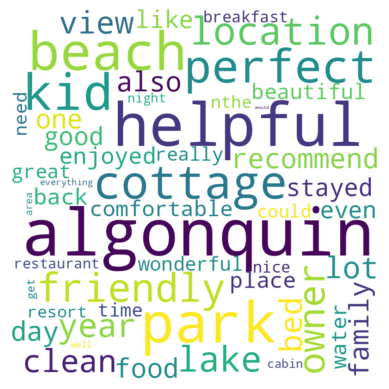

In [51]:
# Generate the word cloud for positive reviews
plotWordCloud(pmiposdf_pos["pmi"].to_dict(), **wordcloud_args)

In [52]:
# Calculate the top-50 words according to PMI for negative reviews
pmiposdf_neg = pmiForAllCal(cleaned_finaldf, top_50_negative, "negative").sort_values("pmi", ascending=0)

100%|██████████| 50/50 [00:00<00:00, 598.45it/s]


In [53]:
pmiposdf_neg

pmi
harry        0.737776
carol        0.716942
inn          0.550152
u2019s       0.531996
breakfast    0.492785
host         0.492425
best         0.413102
could        0.398346
spa          0.385849
like         0.346668
made         0.344372
make         0.336639
u2019t       0.303036
even          0.28905
much          0.28905
back          0.27252
water          0.2547
wonderful    0.214326
dinner       0.206985
time         0.200336
really       0.199438
food         0.188911
every        0.171267
also         0.155854
lot          0.128964
nwe          0.110757
day          0.078485
pool         0.077079
bed          0.072098
beautiful    0.038507
one          0.018653
well         0.003774
everything   0.003774
would        0.001368
area        -0.024341
get         -0.034899
night       -0.047753
nice         -0.07282
resort      -0.083471
nthe        -0.088244
need        -0.103993
great       -0.123336
comfortable -0.147668
place       -0.153898
stayed      -0.188128
good        -0.206028
family      -0.242395
clean       -0.267238
year        -0.291646
lake        -0.346479

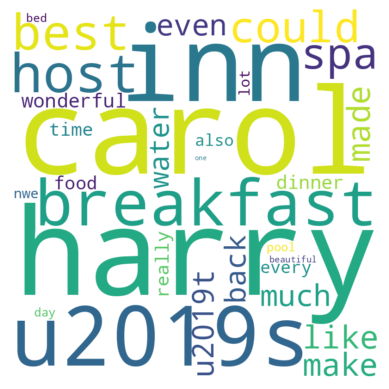

In [54]:
# Generate the word cloud for negative reviews
plotWordCloud(pmiposdf_neg["pmi"].to_dict(), **wordcloud_args)

From the outputs above, the first interesting finding is "algonquin" in positive reviews. The high PMI value of "algonquin" in positive reviews suggests that this location is a significant draw for guests and is associated with positive experiences. The mention could reflect the value guests place on the natural beauty or the recreational opportunities provided by Algonquin Park, indicating that proximity to natural attractions is a strong point for these hotels. And then, the second interesting finding is "harry" in negative reviews. The name "harry" having a high PMI in negative reviews may indicate a person (possibly a staff member) frequently mentioned in less favorable contexts. This could imply individual staff actions or attitudes have a substantial impact on guest satisfaction, or it could be a reflection of a specific incident that has affected multiple guests' experiences. Lastly, the third interesting finding is the locale-specific term and sentiment. The presence of terms like "cottage," "beach," "park," and "lake" in both positive and negative reviews, with varying PMI scores, suggests that these locale-specific aspects are critical to guests' experiences. It appears that when these aspects meet or exceed expectations, they contribute positively, but when they fall short, they are a source of dissatisfaction. This duality emphasizes the need for consistency in the quality of facilities and services provided.

In [55]:
# Calculate the top-50 words according to PMI for positive reviews
pmiposdf_pos_np = pmiForAllCal(cleaned_finaldf, top_50_np_positive, "positive").sort_values("pmi", ascending=0)

100%|██████████| 50/50 [00:00<00:00, 385.94it/s]


In [56]:
pmiposdf_pos_np

pmi
algonquin   0.133928
kitchen     0.097672
kayak       0.078674
kid         0.078674
motel       0.078674
cottage     0.066614
location    0.062548
owner       0.060162
paddle      0.057529
ground      0.055702
lake        0.052725
couple      0.050457
week        0.046413
year        0.045709
view        0.041029
family      0.039026
minute      0.032787
canoe       0.030384
place        0.02603
resort      0.014698
thing       0.013776
restaurant  0.010314
home        0.009797
night       0.008584
cabin       0.007127
summer      0.006321
wood        0.006321
area        0.004436
everything -0.000699
pool       -0.014925
day         -0.01521
meal       -0.017231
lot        -0.025779
service    -0.026099
experience -0.035148
trail      -0.037993
food       -0.039202
time       -0.041875
dinner     -0.043447
property   -0.043928
way        -0.044502
evening    -0.047025
water      -0.055122
guest      -0.065474
husband    -0.088183
fireplace  -0.088183
heather    -0.110656
host       -0.125154
carol       -0.21541
harry      -0.225348

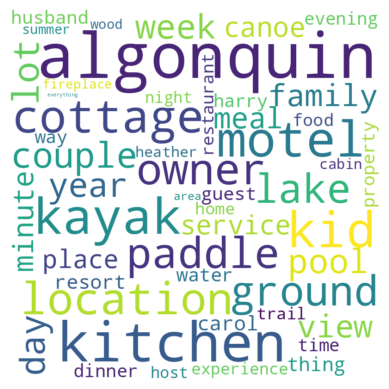

In [57]:
# Generate the word cloud for positive reviews
plotWordCloud(pmiposdf_pos_np["pmi"].to_dict(), **wordcloud_args)

In [58]:
# Calculate the top-50 words according to PMI for negative reviews
pmiposdf_neg_np = pmiForAllCal(cleaned_finaldf, top_50_np_negative, "positive").sort_values("pmi", ascending=0)

100%|██████████| 50/50 [00:00<00:00, 593.05it/s]


In [59]:
pmiposdf_neg_np

pmi
kid         0.078674
motel       0.078674
cottage     0.066614
owner       0.060162
lake        0.052725
year        0.045709
family      0.039026
minute      0.032787
canoe       0.030384
place        0.02603
price       0.023042
resort      0.014698
thing       0.013776
restaurant  0.010314
home        0.009797
night       0.008584
cabin       0.007127
area        0.004436
everything -0.000699
pool       -0.014925
day         -0.01521
meal       -0.017231
lot        -0.025779
service    -0.026099
trail      -0.037993
food       -0.039202
hot        -0.040426
time       -0.041875
dinner     -0.043447
property   -0.043928
evening    -0.047025
water      -0.055122
amenity    -0.061466
people     -0.062156
guest      -0.065474
something  -0.073976
husband    -0.088183
fireplace  -0.088183
spa         -0.09108
friend     -0.097417
heather    -0.110656
host       -0.125154
inn        -0.145739
furniture  -0.198079
carol       -0.21541
issue      -0.216017
harry      -0.225348
jackie     -0.235819
jim        -0.261137
drink      -0.567953

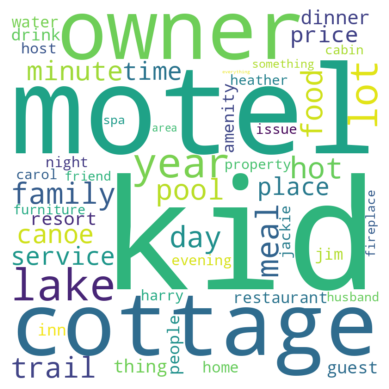

In [60]:
# Generate the word cloud for negative reviews
plotWordCloud(pmiposdf_neg_np["pmi"].to_dict(), **wordcloud_args)

From the outputs above, the first interesting result is "algonquin" dominates positive sentiment. The highest PMI score for "algonquin" in positive reviews suggests that this location or attribute has a very strong positive association with the guests' experiences. This could be due to Algonquin Park being a major attraction, and its mention likely reflects guests' enjoyment of the park's offerings or the hotel's proximity to the park. Hotels in the area may benefit from promoting their access to Algonquin Park or organizing related activities. And then, the second interesting result is outdoor activities highlighted. The prominence of words like "canoe," "kayak," and "paddle" alongside "algonquin" and "lake" indicates that outdoor water activities are a significant part of the attraction for guests. These activities are likely viewed as an integral part of the vacation experience, and their positive mention reflects well on the overall service and facilities related to these offerings. Lastly, the third interesting result is negative for "harry". The fact that "harry" has a negative PMI score in positive reviews is intriguing. This might imply that even within positive contexts, there are some mentions of "harry" that are less favorable, which could highlight a specific issue or an area where guest expectations are not being met consistently.

In [61]:
def plotWordCloud_adj(word_freq_dict, **kwargs):
    # If all PMI values are zero, set them all to a small non-zero value
    if all(value == 0 for value in word_freq_dict.values()):
        word_freq_dict = {word: 0.0001 for word in word_freq_dict.keys()}

    wordcloud = WordCloud(**kwargs).generate_from_frequencies(word_freq_dict)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [62]:
# Calculate the average ground truth rating for each hotel
average_ratings = cleaned_finaldf.groupby("hotelName")["ratingScore"].mean().sort_values()

# Identify the single top and bottom hotels
top_hotel = average_ratings.idxmax()
bottom_hotel = average_ratings.idxmin()

In [63]:
# Filter the reviews for the top and bottom hotels
top_hotel_reviews = cleaned_finaldf[cleaned_finaldf["hotelName"] == top_hotel]
bottom_hotel_reviews = cleaned_finaldf[cleaned_finaldf["hotelName"] == bottom_hotel]

In [64]:
# Calculate PMI for the top hotel for positive reviews of top hotel
pmiposdf_pos_c = pmiForAllCal(top_hotel_reviews, top_50_positive, "positive").sort_values("pmi", ascending=0)

100%|██████████| 50/50 [00:00<00:00, 1009.28it/s]


In [65]:
pmiposdf_pos_c

pmi
great        0.0
kid          0.0
beautiful    0.0
nthe         0.0
water        0.0
bed          0.0
lot          0.0
wonderful    0.0
really       0.0
get          0.0
everything   0.0
like         0.0
cabin        0.0
place        0.0
need         0.0
could        0.0
recommend    0.0
owner        0.0
restaurant   0.0
enjoyed      0.0
helpful      0.0
location     0.0
even         0.0
beach        0.0
view         0.0
food         0.0
also         0.0
comfortable  0.0
clean        0.0
lake         0.0
resort       0.0
time         0.0
would        0.0
well         0.0
day          0.0
cottage      0.0
stayed       0.0
night        0.0
park         0.0
family       0.0
one          0.0
back         0.0
area         0.0
friendly     0.0
nice         0.0
good         0.0
year         0.0
algonquin    0.0
breakfast    0.0
perfect      0.0

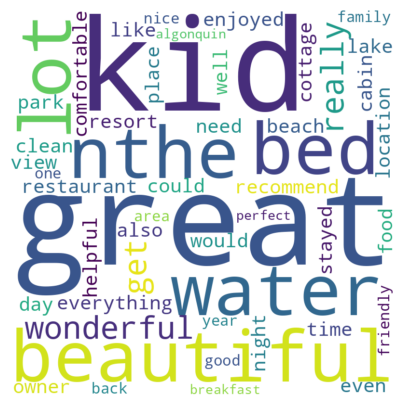

In [66]:
# Generate the word cloud for positive reviews of top hotel
plotWordCloud_adj(pmiposdf_pos_c["pmi"].to_dict(), **wordcloud_args)

In [67]:
# Calculate PMI for the top hotel for negative reviews of top hotel
pmiposdf_neg_c = pmiForAllCal(top_hotel_reviews, top_50_negative, "negative").sort_values("pmi", ascending=0)

100%|██████████| 50/50 [00:00<00:00, 959.43it/s]


In [68]:
pmiposdf_neg_c

pmi
time         9.21034
family       9.21034
breakfast    9.21034
nice         9.21034
like         9.21034
much         9.21034
good         9.21034
need         9.21034
spa          9.21034
bed          9.21034
comfortable  9.21034
beautiful    9.21034
one          9.21034
make         9.21034
pool         9.21034
dinner       9.21034
get          9.21034
year         9.21034
everything   9.21034
nwe          9.21034
every        9.21034
made         9.21034
stayed       9.21034
water        9.21034
host         9.21034
really       9.21034
would        9.21034
great        9.21034
place        9.21034
back         9.21034
resort       9.21034
day          9.21034
night        9.21034
well         9.21034
could        9.21034
inn          9.21034
also         9.21034
harry        9.21034
u2019s       9.21034
area         9.21034
carol        9.21034
food         9.21034
best         9.21034
u2019t           0.0
even             0.0
lake             0.0
lot              0.0
clean            0.0
wonderful        0.0
nthe             0.0

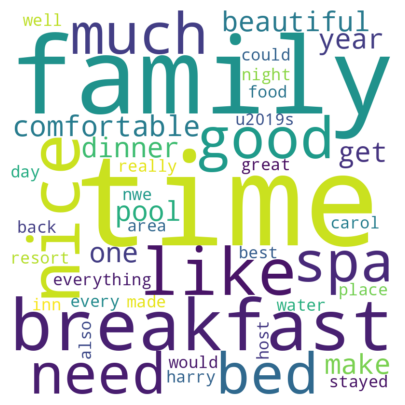

In [69]:
# Generate the word cloud for negative reviews of top hotel
plotWordCloud_adj(pmiposdf_neg_c["pmi"].to_dict(), **wordcloud_args)

In [70]:
# Calculate PMI for the top hotel for positive reviews of top hotel
pmiposdf_pos_c_np = pmiForAllCal(top_hotel_reviews, top_50_np_positive, "positive").sort_values("pmi", ascending=0)

100%|██████████| 50/50 [00:00<00:00, 1169.48it/s]


In [71]:
pmiposdf_pos_c_np

pmi
place       0.0
kayak       0.0
location    0.0
pool        0.0
paddle      0.0
meal        0.0
motel       0.0
way         0.0
husband     0.0
service     0.0
thing       0.0
kitchen     0.0
ground      0.0
resort      0.0
wood        0.0
minute      0.0
heather     0.0
couple      0.0
lot         0.0
trail       0.0
evening     0.0
experience  0.0
summer      0.0
week        0.0
host        0.0
home        0.0
canoe       0.0
dinner      0.0
lake        0.0
cottage     0.0
night       0.0
day         0.0
everything  0.0
food        0.0
area        0.0
time        0.0
family      0.0
algonquin   0.0
owner       0.0
kid         0.0
carol       0.0
year        0.0
cabin       0.0
guest       0.0
harry       0.0
view        0.0
restaurant  0.0
property    0.0
water       0.0
fireplace   0.0

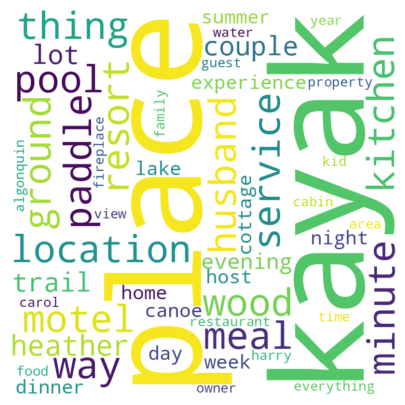

In [72]:
# Generate the word cloud for positive reviews of top hotel
plotWordCloud_adj(pmiposdf_pos_c_np["pmi"].to_dict(), **wordcloud_args)

In [73]:
# Calculate PMI for the top hotel for negative reviews of top hotel
pmiposdf_neg_c_np = pmiForAllCal(top_hotel_reviews, top_50_np_negative, "negative").sort_values("pmi", ascending=0)

100%|██████████| 50/50 [00:00<00:00, 1090.41it/s]


In [74]:
pmiposdf_neg_c_np

pmi
harry       9.21034
place       9.21034
husband     9.21034
meal        9.21034
friend      9.21034
water       9.21034
cottage     9.21034
kid         9.21034
property    9.21034
fireplace   9.21034
home        9.21034
canoe       9.21034
drink       9.21034
thing       9.21034
motel       9.21034
heather     9.21034
minute      9.21034
evening     9.21034
furniture   9.21034
people      9.21034
amenity     9.21034
price       9.21034
something   9.21034
hot         9.21034
restaurant  9.21034
service     9.21034
owner       9.21034
carol       9.21034
time        9.21034
day         9.21034
resort      9.21034
food        9.21034
night       9.21034
everything  9.21034
cabin       9.21034
family      9.21034
host        9.21034
guest       9.21034
area        9.21034
spa         9.21034
inn         9.21034
jim         9.21034
jackie      9.21034
dinner      9.21034
year        9.21034
pool        9.21034
issue       9.21034
lake            0.0
lot             0.0
trail           0.0

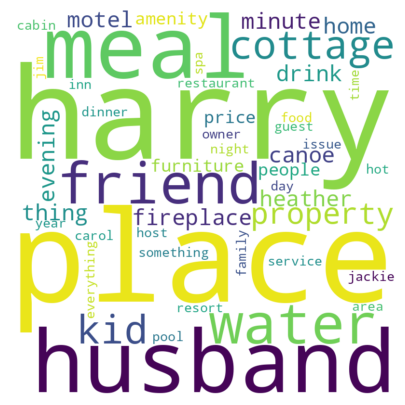

In [75]:
# Generate the word cloud for negative reviews of top hotel
plotWordCloud_adj(pmiposdf_neg_c_np["pmi"].to_dict(), **wordcloud_args)

In [76]:
# Calculate PMI for the top hotel for positive reviews of bottom hotel
pmiposdf_pos_d = pmiForAllCal(bottom_hotel_reviews, top_50_positive, "negative").sort_values("pmi", ascending=0)

100%|██████████| 50/50 [00:00<00:00, 1095.74it/s]


In [77]:
pmiposdf_pos_d

pmi
perfect      0.587787
like         0.587787
view         0.587787
nice         0.587787
nthe         0.587787
water        0.587787
bed          0.587787
everything   0.587787
family       0.587787
park         0.587787
kid          0.587787
algonquin    0.587787
cottage      0.587787
cabin        0.587787
could        0.587787
restaurant   0.587787
location     0.587787
resort       0.587787
even         0.587787
beach        0.587787
year         0.587787
great        0.300105
time         0.182322
stayed       0.182322
breakfast         0.0
also        -0.105361
place       -0.105361
enjoyed     -0.105361
would       -0.105361
back        -0.105361
day         -0.105361
comfortable -0.105361
get         -0.510826
well        -0.510826
food        -0.510826
area        -0.798508
really      -8.622554
lot         -8.622554
recommend   -8.622554
owner       -8.622554
friendly    -8.622554
beautiful   -8.622554
helpful     -8.622554
lake        -8.622554
one         -9.315701
wonderful   -9.315701
good        -9.315701
clean       -9.315701
night       -9.315701
need        -9.721166

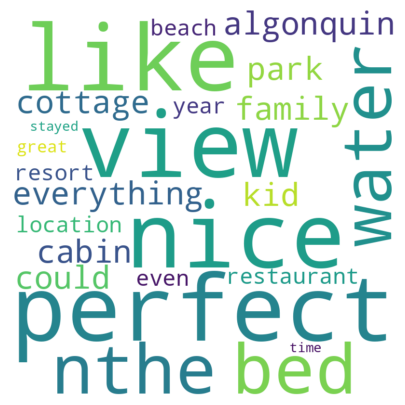

In [78]:
# Generate the word cloud for positive reviews of bottom hotel
plotWordCloud_adj(pmiposdf_pos_d["pmi"].to_dict(), **wordcloud_args)

In [79]:
# Calculate PMI for the top hotel for negative reviews of bottom hotel
pmiposdf_neg_d = pmiForAllCal(bottom_hotel_reviews, top_50_negative, "positive").sort_values("pmi", ascending=0)

100%|██████████| 50/50 [00:00<00:00, 708.61it/s]


In [80]:
pmiposdf_neg_d

pmi
water         0.81093
harry         0.81093
need          0.81093
spa           0.81093
one           0.81093
family        0.81093
really        0.81093
carol         0.81093
u2019s        0.81093
clean         0.81093
lot           0.81093
good          0.81093
lake          0.81093
beautiful     0.81093
could         0.81093
night         0.81093
pool          0.81093
resort        0.81093
nthe          0.81093
wonderful     0.81093
area         0.523248
well         0.405465
food         0.405465
get          0.405465
make         0.117783
every        0.117783
comfortable  0.117783
made         0.117783
best         0.117783
also         0.117783
would        0.117783
place        0.117783
back         0.117783
day          0.117783
breakfast         0.0
host        -0.105361
inn         -0.287682
nwe         -0.287682
time        -0.287682
stayed      -0.287682
great       -0.575364
u2019t       -8.39941
dinner       -8.39941
even         -8.39941
year         -8.39941
everything   -8.39941
nice         -8.39941
much         -8.39941
like        -9.092557
bed         -9.092557

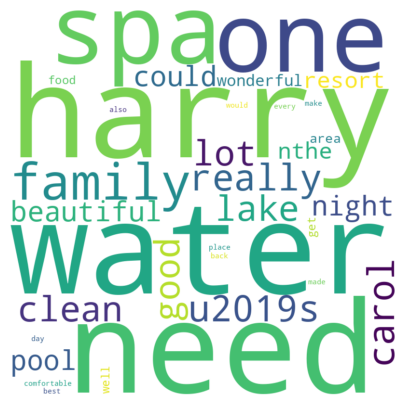

In [81]:
# Generate the word cloud for negative reviews of bottom hotel
plotWordCloud_adj(pmiposdf_neg_d["pmi"].to_dict(), **wordcloud_args)

In [82]:
# Calculate PMI for the top hotel for positive reviews of bottom hotel
pmiposdf_pos_d_np = pmiForAllCal(bottom_hotel_reviews, top_50_np_positive, "positive").sort_values("pmi", ascending=0)

100%|██████████| 50/50 [00:00<00:00, 867.20it/s]


In [83]:
pmiposdf_pos_d_np

pmi
home         0.81093
water        0.81093
resort       0.81093
location     0.81093
pool         0.81093
paddle       0.81093
meal         0.81093
motel        0.81093
way          0.81093
husband      0.81093
service      0.81093
kitchen      0.81093
kayak        0.81093
ground       0.81093
heather      0.81093
lot          0.81093
evening      0.81093
experience   0.81093
summer       0.81093
canoe        0.81093
fireplace    0.81093
carol        0.81093
family       0.81093
lake         0.81093
view         0.81093
harry        0.81093
cottage      0.81093
night        0.81093
cabin        0.81093
restaurant   0.81093
kid          0.81093
owner        0.81093
algonquin    0.81093
area        0.523248
food        0.405465
wood        0.117783
couple      0.117783
day         0.117783
thing       0.117783
place       0.117783
guest       0.117783
trail      -0.105361
host       -0.105361
property   -0.105361
time       -0.287682
minute      -8.39941
everything  -8.39941
year        -8.39941
dinner      -8.39941
week        -8.39941

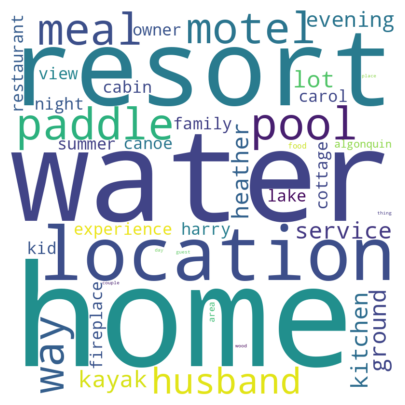

In [84]:
# Generate the word cloud for positive reviews of bottom hotel
plotWordCloud_adj(pmiposdf_pos_d_np["pmi"].to_dict(), **wordcloud_args)

In [85]:
# Calculate PMI for the top hotel for negative reviews of bottom hotel
pmiposdf_neg_d_np = pmiForAllCal(bottom_hotel_reviews, top_50_np_negative, "positive").sort_values("pmi", ascending=0)

100%|██████████| 50/50 [00:00<00:00, 1203.99it/s]


In [86]:
pmiposdf_neg_d_np

pmi
harry        0.81093
pool         0.81093
service      0.81093
hot          0.81093
husband      0.81093
meal         0.81093
water        0.81093
cottage      0.81093
kid          0.81093
fireplace    0.81093
home         0.81093
canoe        0.81093
drink        0.81093
motel        0.81093
heather      0.81093
evening      0.81093
furniture    0.81093
people       0.81093
amenity      0.81093
price        0.81093
something    0.81093
owner        0.81093
restaurant   0.81093
issue        0.81093
lake         0.81093
carol        0.81093
resort       0.81093
night        0.81093
cabin        0.81093
spa          0.81093
lot          0.81093
family       0.81093
area        0.523248
food        0.405465
place       0.117783
day         0.117783
thing       0.117783
guest       0.117783
host       -0.105361
property   -0.105361
trail      -0.105361
jim        -0.169899
jackie     -0.169899
inn        -0.287682
time       -0.287682
everything  -8.39941
minute      -8.39941
friend      -8.39941
dinner      -8.39941
year        -8.39941

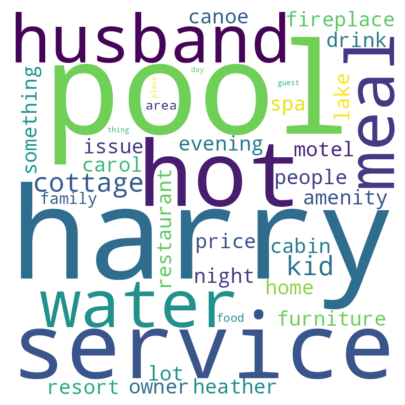

In [87]:
# Generate the word cloud for negative reviews of bottom hotel
plotWordCloud_adj(pmiposdf_neg_d_np["pmi"].to_dict(), **wordcloud_args)

From the output above, I did not gain many useful hotel-specific insights about what is good and bad about these two hotels. The reason why this happened is that due to the limited size of the review dataset for both top and bottom hotels, most PMI values are the same or very similar, which can hinder the ability to gain meaningful hotel-specific insights. When the dataset is not large enough to provide a wide variety of contexts in which words appear, the PMI calculation may not be as informative. This is because PMI relies on the variability of word occurrences across different contexts to determine the strength of association with positive or negative sentiments.

In [88]:
def getHistogram(df, measure, title,figsize=(10,5)):
    fig = plt.figure(figsize=figsize)
    plt.title(title)

    if measure=='both':
        x = [df['ratingScore'].values/5]
        y = [df['vader'].values]
        bins = np.linspace(-1, 1, 100)
        plt.hist(x, bins, label='normalized Ground Truth')
        plt.hist(y, bins, label='vader')
        plt.legend(loc='upper right')
        plt.xlabel("Value")
        plt.ylabel("Frequency")
    else:
        plt.hist(df[measure].values)

    plt.xlabel("Value")
    plt.ylabel("Frequency")

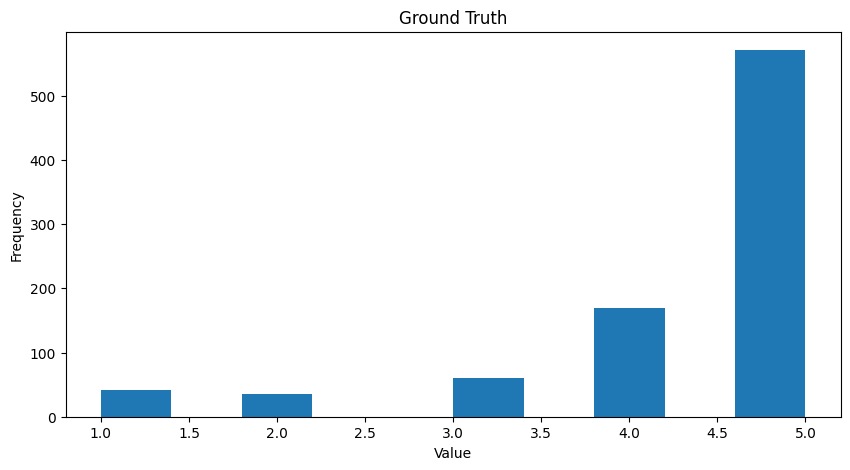

In [89]:
# Show the histogram of the ground truth
getHistogram(cleaned_finaldf, "ratingScore", "Ground Truth")

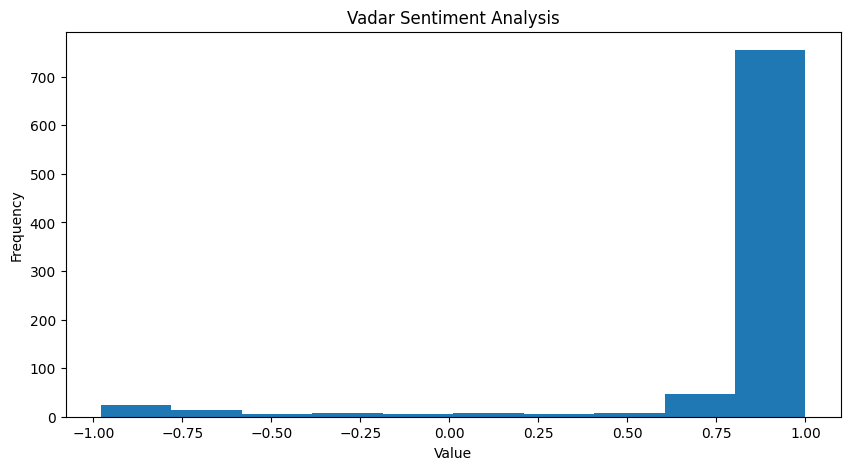

In [90]:
# Show the histogram of the vader sentiment scores
getHistogram(cleaned_finaldf, "vader", "Vadar Sentiment Analysis")

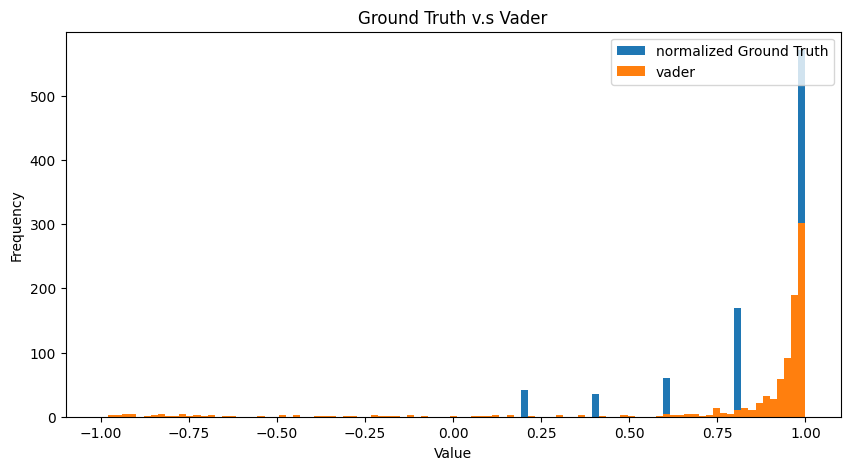

In [91]:
# Show the histogram of comparing between ground truth and vader
getHistogram(cleaned_finaldf, "both", "Ground Truth v.s Vader")

From the outputs above, we can see that the histogram for ground truth sentiment scores appears to be heavily skewed towards the higher end of the scale. This suggests that most of the reviews in your dataset are positive, with a high frequency of scores close to 1. The lack of lower score frequencies indicates fewer negative reviews. However, compared with the histogram for ground truth sentiment scores, the Vader sentiment scores show a broader distribution across the range from -1 to 1. There is a noticeable concentration of scores at the extreme ends, indicating a significant number of reviews with strong positive or negative sentiment. The spread of Vader scores, including those in the negative range, is more uniform compared to the ground truth distribution. This could suggest that Vader is picking up on subtler expressions of sentiment that are not reflected in the star ratings. The comparison between the two histograms reveals that Vader sentiment analysis captures a wider and more balanced range of sentiments than the ground truth star ratings. This may not be surprising as textual reviews can express nuanced sentiments, while star ratings are limited to a fixed scale and may not capture moderate or neutral feelings as effectively.


In [92]:
# Count the number of reviews per hotel
reviews_per_hotel = cleaned_finaldf["hotelName"].value_counts()

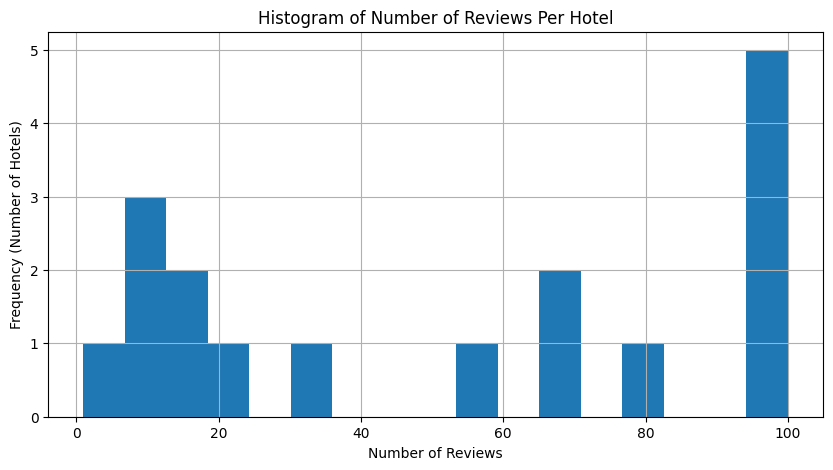

In [93]:
# Plot the histogram of the number of reviews per hotel
plt.figure(figsize=(10, 5))
reviews_per_hotel.hist(bins=len(reviews_per_hotel))
plt.title("Histogram of Number of Reviews Per Hotel")
plt.xlabel("Number of Reviews")
plt.ylabel("Frequency (Number of Hotels)")
plt.show()

The histogram of the number of reviews per hotel reveals a bimodal distribution, with clear peaks around the lower end and at the higher end of the review count spectrum, and a notable dearth of hotels in the intermediate range. This pattern suggests a division within the dataset, where a subset of hotels garners a high number of reviews, likely reflecting their popularity or a proactive approach to soliciting feedback, while the majority have significantly fewer reviews, which could indicate smaller, less frequented, or newer establishments. The absence of a gradual slope between these two peaks implies that few hotels occupy the middle ground in terms of review quantity, which might be symptomatic of a polarized market where hotels are either well-established and commonly reviewed or are relatively obscure and infrequently reviewed.

In [94]:
print(avg_vader_rank.head(5))
print(avg_vader_rank.tail(5))
print(median_vader_rank.head(5))
print(median_vader_rank.tail(5))

                          hotelName     vader
11            Silver Eagle Cottages  0.977994
12      Sir Sam&#39;s Inn &amp; Spa  0.966692
1   Christie&#39;s Mill Inn and Spa  0.963300
6               Logging Chain Lodge  0.948700
8        Muskoka Waterfront Retreat  0.941300
                     hotelName     vader
4       Heidi&#39;s Campground  0.770411
9                Rawley Resort  0.729826
14   Sun Retreats Georgian Bay  0.728825
7   Loralea Country Inn Resort  0.727149
15             Sunnylea Resort  0.646632
                          hotelName   vader
4            Heidi&#39;s Campground  0.9900
12      Sir Sam&#39;s Inn &amp; Spa  0.9848
11            Silver Eagle Cottages  0.9820
1   Christie&#39;s Mill Inn and Spa  0.9785
16         The Pines Cottage Resort  0.9771
                     hotelName    vader
3        Fern Glen Inn B&amp;B  0.95445
5     Lakewoods Cottage Resort  0.94740
7   Loralea Country Inn Resort  0.94590
8   Muskoka Waterfront Retreat  0.94130
14   Sun Retre

In [95]:
top_bottom_hotels = ["Silver Eagle Cottages", "Sir Sam&#39;s Inn &amp; Spa", "Christie&#39;s Mill Inn and Spa",
                     "Logging Chain Lodge", "Muskoka Waterfront Retreat", "Heidi&#39;s Campground",
                     "Rawley Resort", "Sun Retreats Georgian Bay", "Loralea Country Inn Resort",
                     "Sunnylea Resort", "The Pines Cottage Resort", "Fern Glen Inn B&amp;B",
                     "Lakewoods Cottage Resort"]

In [96]:
# Filter the DataFrame to exclude hotels that are in the top-5 or bottom-5 of both rankings
filtered_hotels_df = cleaned_finaldf[~cleaned_finaldf["hotelName"].isin(top_bottom_hotels)]

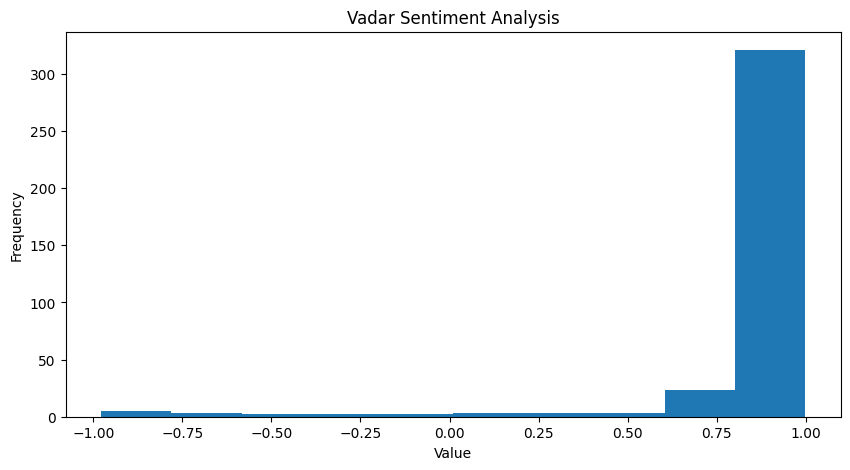

In [97]:
# Show the histogram of the vader sentiment scores
getHistogram(filtered_hotels_df, "vader", "Vadar Sentiment Analysis")

In [98]:
print(avg_rating_rank.head(5))

                    hotelName  ratingScore
8  Muskoka Waterfront Retreat     5.000000
3       Fern Glen Inn B&amp;B     4.964286
6         Logging Chain Lodge     4.833333
0          Blue Spruce Resort     4.820000
7  Loralea Country Inn Resort     4.791045


In [99]:
# Filter the DataFrame to include only the top-5 ranked hotels
top_5_hotels_gt = ["Muskoka Waterfront Retreat", "Fern Glen Inn B&amp;B", "Logging Chain Lodge",
                   "Blue Spruce Resort", "Loralea Country Inn Resort"]

hotel_list_gt = []
for hotel in top_5_hotels_gt:
  _hotel = cleaned_finaldf.loc[cleaned_finaldf["hotelName"] == hotel]["ratingScore"]
  hotel_list_gt.append(_hotel)

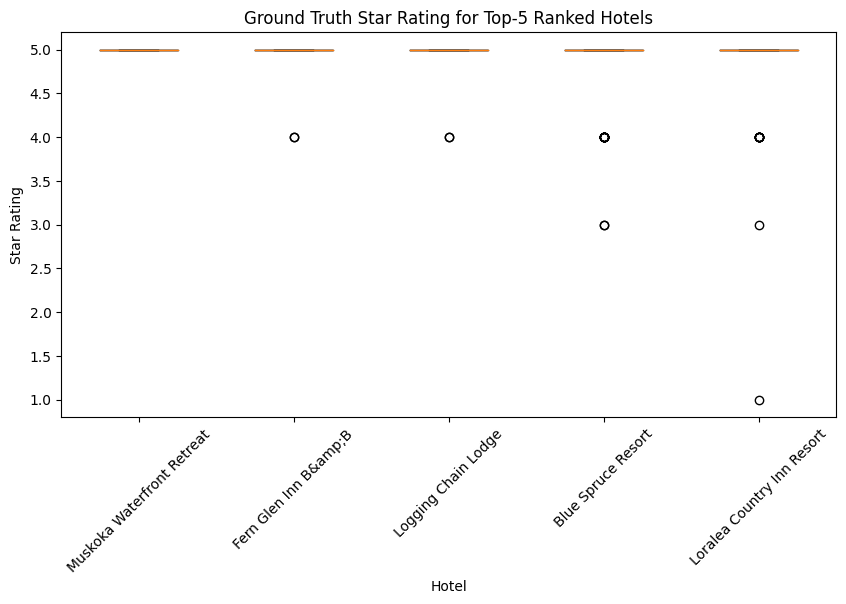

In [100]:
# Create side-by-side boxplots for ground truth star ratings for these hotels
plt.figure(figsize=(10, 5))
plt.boxplot(hotel_list_gt)
plt.xticks(np.arange(1, 6), top_5_hotels_gt ,rotation=45)
plt.title("Ground Truth Star Rating for Top-5 Ranked Hotels")
plt.xlabel("Hotel")
plt.ylabel("Star Rating")
plt.show()

In [101]:
print(avg_vader_rank.head(5))

                          hotelName     vader
11            Silver Eagle Cottages  0.977994
12      Sir Sam&#39;s Inn &amp; Spa  0.966692
1   Christie&#39;s Mill Inn and Spa  0.963300
6               Logging Chain Lodge  0.948700
8        Muskoka Waterfront Retreat  0.941300


In [102]:
# Filter the DataFrame to include only the top-5 ranked hotels
top_5_hotels_vader = ["Silver Eagle Cottages", "Sir Sam&#39;s Inn &amp; Spa", "Christie&#39;s Mill Inn and Spa",
                      "Logging Chain Lodge", "Muskoka Waterfront Retreat"]

hotel_list_vader = []
for hotel in top_5_hotels_vader:
  hotel_ = cleaned_finaldf.loc[cleaned_finaldf["hotelName"] == hotel]["ratingScore"]
  hotel_list_vader.append(hotel_)

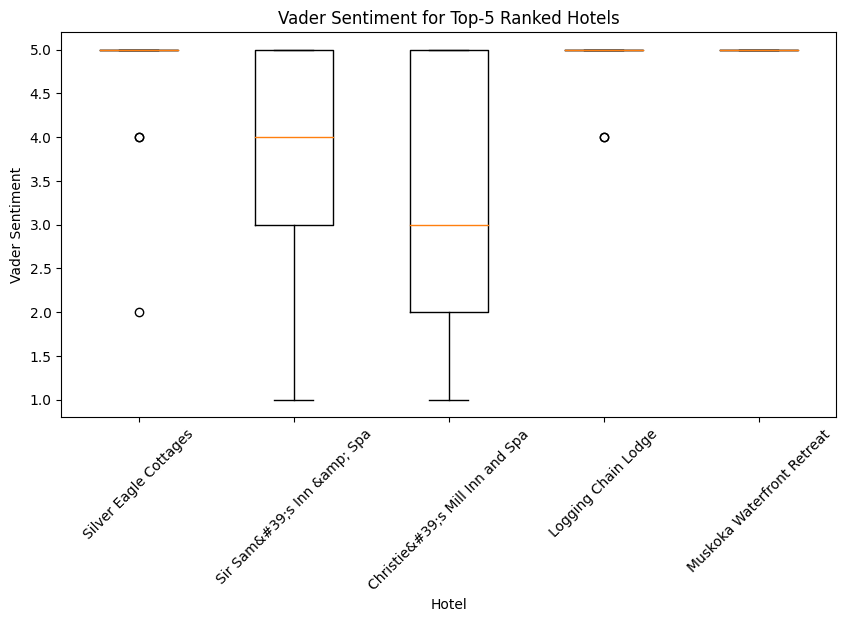

In [103]:
# Create side-by-side boxplots for vader sentiment for these hotels
plt.figure(figsize=(10, 5))
plt.boxplot(hotel_list_vader)
plt.xticks(np.arange(1, 6), top_5_hotels_vader ,rotation=45)
plt.title("Vader Sentiment for Top-5 Ranked Hotels")
plt.xlabel("Hotel")
plt.ylabel("Vader Sentiment")
plt.show()

In [104]:
# Calculate the mean and variance for ground truth scores for top-5 ground truth hotels
top_5_gt_df = cleaned_finaldf[cleaned_finaldf["hotelName"].isin(top_5_hotels_gt)]
mean_gt = top_5_gt_df["ratingScore"].mean()
variance_gt = top_5_gt_df["ratingScore"].var()

print(f"Mean of the ground truth for the top-5 ranked hotels: {mean_gt}")
print(f"Variance of the ground truth for the top-5 ranked hotels: {variance_gt}")

Mean of the ground truth for the top-5 ranked hotels: 4.8474576271186445
Variance of the ground truth for the top-5 ranked hotels: 0.20641904075009007


In [105]:
# Calculate the mean and variance for Vader scores for top-5 Vader hotels
top_5_vader_df = cleaned_finaldf[cleaned_finaldf["hotelName"].isin(top_5_hotels_vader)]
mean_vader = top_5_vader_df["vader"].mean()
variance_vader = top_5_vader_df["vader"].var()

print(f"Mean of the Vader sentiment scores for the top-5 ranked hotels: {mean_vader}")
print(f"Variance of the Vader sentiment scores for the top-5 ranked hotels: {variance_vader}")

Mean of the Vader sentiment scores for the top-5 ranked hotels: 0.9659295302013422
Variance of the Vader sentiment scores for the top-5 ranked hotels: 0.0026222177707237427


From the outputs above, we can know that boxplots are generally more informative for understanding the shape of the distribution and identifying outliers. They can reveal asymmetry in the distribution and help you understand the data at a glance. The mean and variance provide a more abstract numerical summary and are useful for comparisons and further statistical analysis. Therefore, I think that boxplots and mean/variance are complementary which means that they are equally informative. For a comprehensive analysis, both should be used in conjunction.

In [106]:
# Extracting the rating scores and vader scores
rating_scores = cleaned_finaldf["ratingScore"].values
vader_scores = cleaned_finaldf["vader"].values

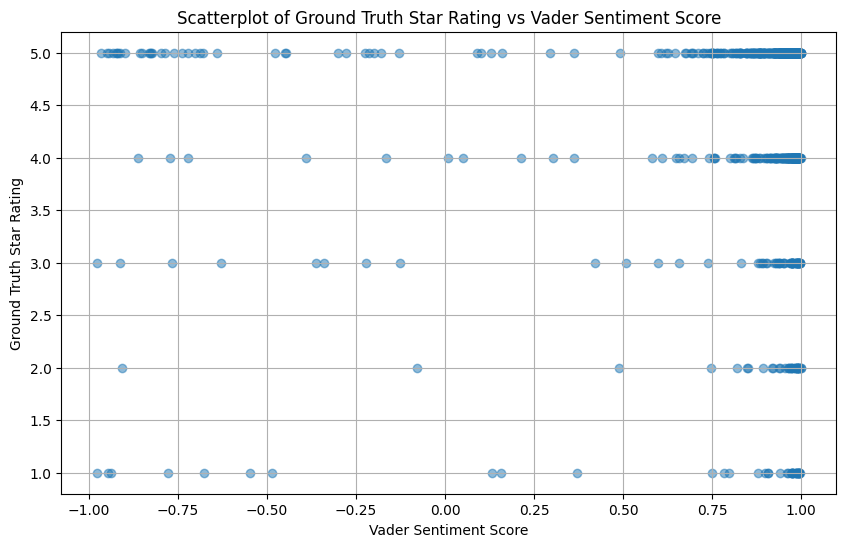

In [107]:
# Creating the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(vader_scores, rating_scores, alpha=0.5)
plt.title("Scatterplot of Ground Truth Star Rating vs Vader Sentiment Score")
plt.xlabel("Vader Sentiment Score")
plt.ylabel("Ground Truth Star Rating")
plt.grid(True)
plt.show()

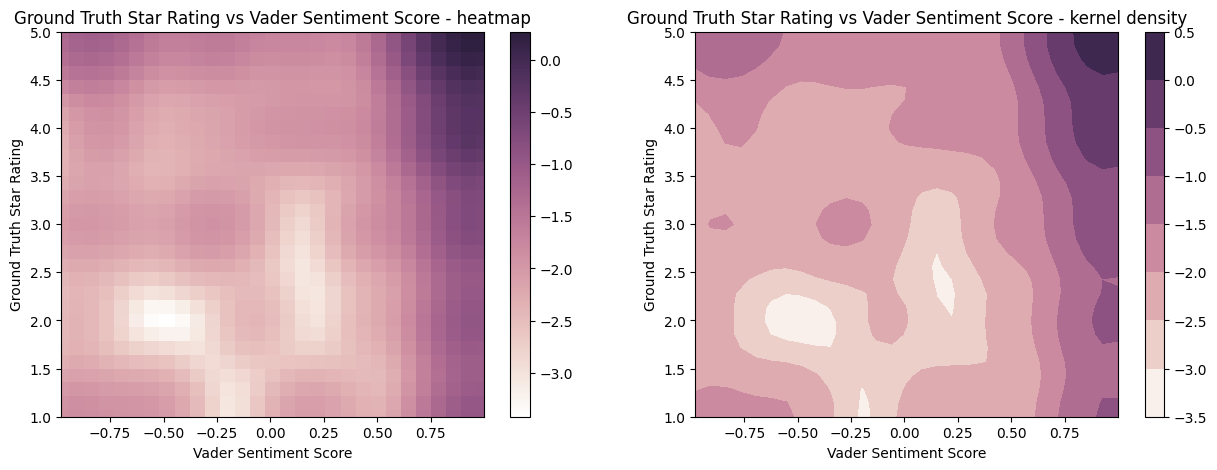

In [108]:
# Calculate the point density
k_c1 = gaussian_kde(np.vstack([vader_scores, rating_scores]))
xi_c1, yi_c1 = np.mgrid[vader_scores.min():vader_scores.max():vader_scores.size**0.5*1j,rating_scores.min():rating_scores.max():rating_scores.size**0.5*1j]
zi_c1 = k_c1(np.vstack([xi_c1.flatten(), yi_c1.flatten()]))

# Creating the heatmap
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(15, 5))
b1_c1 = ax1.pcolormesh(xi_c1, yi_c1, np.log10(zi_c1.reshape(xi_c1.shape)), cmap=cmap)
b2_c1 = ax2.contourf(xi_c1, yi_c1, np.log10(zi_c1.reshape(xi_c1.shape)), cmap=cmap)
ax1.set_xlim(vader_scores.min(), vader_scores.max())
ax1.set_ylim(rating_scores.min(), rating_scores.max())
ax2.set_xlim(vader_scores.min(), vader_scores.max())
ax2.set_ylim(rating_scores.min(), rating_scores.max())
ax1.set_xlabel("Vader Sentiment Score")
ax1.set_ylabel("Ground Truth Star Rating")
ax2.set_xlabel("Vader Sentiment Score")
ax2.set_ylabel("Ground Truth Star Rating")
fig.colorbar(b1_c1, ax=ax1)
fig.colorbar(b2_c1, ax=ax2)
ax1.set_title("Ground Truth Star Rating vs Vader Sentiment Score - heatmap")
ax2.set_title("Ground Truth Star Rating vs Vader Sentiment Score - kernel density");


The scatterplot of Rating vs. Vader scores illustrates a concentration of reviews in the higher Vader score and star rating range, indicating a correlation between positive sentiment analysis and higher star ratings. The dense clustering at the top right, with a spread towards the lower-left, suggests that while positive Vader scores tend to match high star ratings, lower Vader scores are distributed across various star ratings. This could mean that negative sentiment in text does not always correspond to a lower star rating. The heatmap reinforces this, showing hotspots of density around higher ratings and Vader scores but less correlation in the lower ranges. These visualizations indicate that while positive reviews are consistently reflected in both Vader and star ratings, negative sentiment is not as straightforwardly mirrored in the numerical star ratings, perhaps due to the subjective nature of text sentiment and the multi-faceted reasons for giving a particular star rating.

In [109]:
# Calculate review lengths
new_cleaned_finaldf = cleaned_finaldf.copy()
new_cleaned_finaldf["reviewLength"] = new_cleaned_finaldf["reviewCol"].apply(len)
review_length = new_cleaned_finaldf["reviewLength"].values

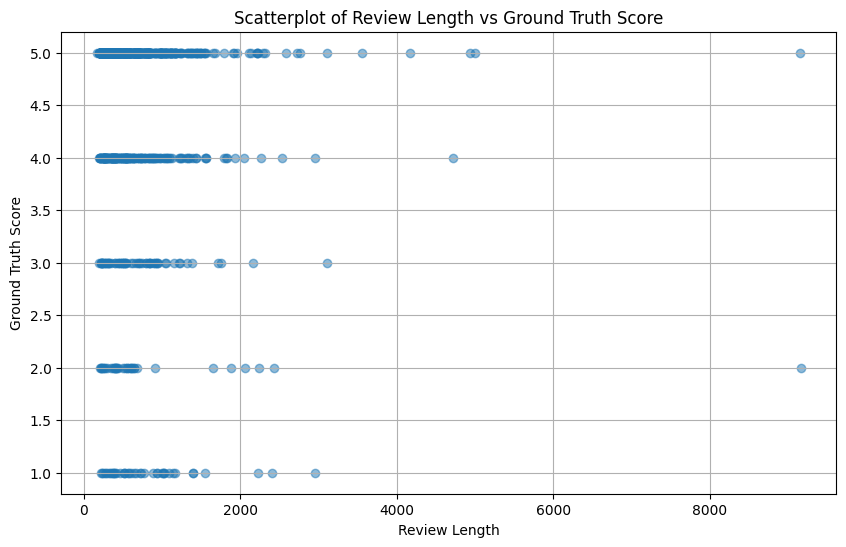

In [110]:
# Create scatterplots for Ground Truth Score vs Review Length
plt.figure(figsize=(10, 6))
plt.scatter(review_length, rating_scores, alpha=0.5)
plt.title("Scatterplot of Review Length vs Ground Truth Score")
plt.xlabel("Review Length")
plt.ylabel("Ground Truth Score")
plt.grid(True)
plt.show()

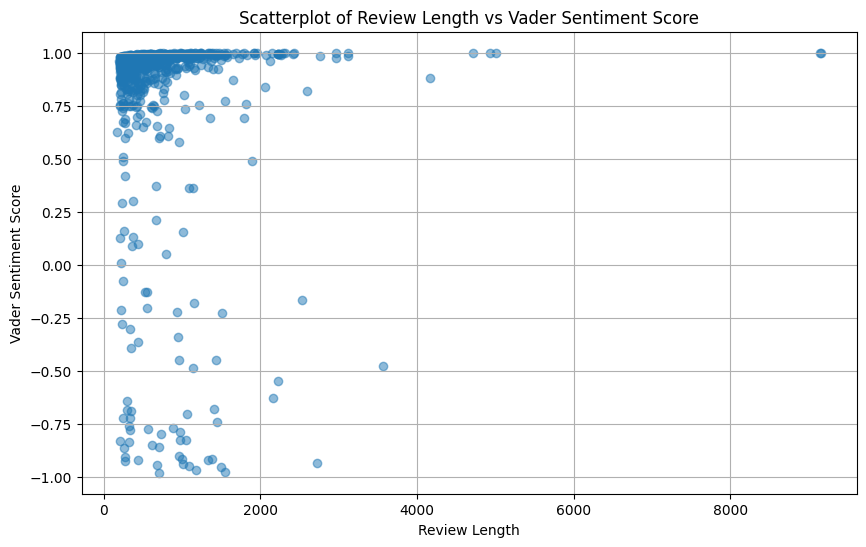

In [111]:
# Create scatterplots for Vader Sentiment Score vs Review Length
plt.figure(figsize=(10, 6))
plt.scatter(review_length, vader_scores, alpha=0.5)
plt.title("Scatterplot of Review Length vs Vader Sentiment Score")
plt.xlabel("Review Length")
plt.ylabel("Vader Sentiment Score")
plt.grid(True)
plt.show()

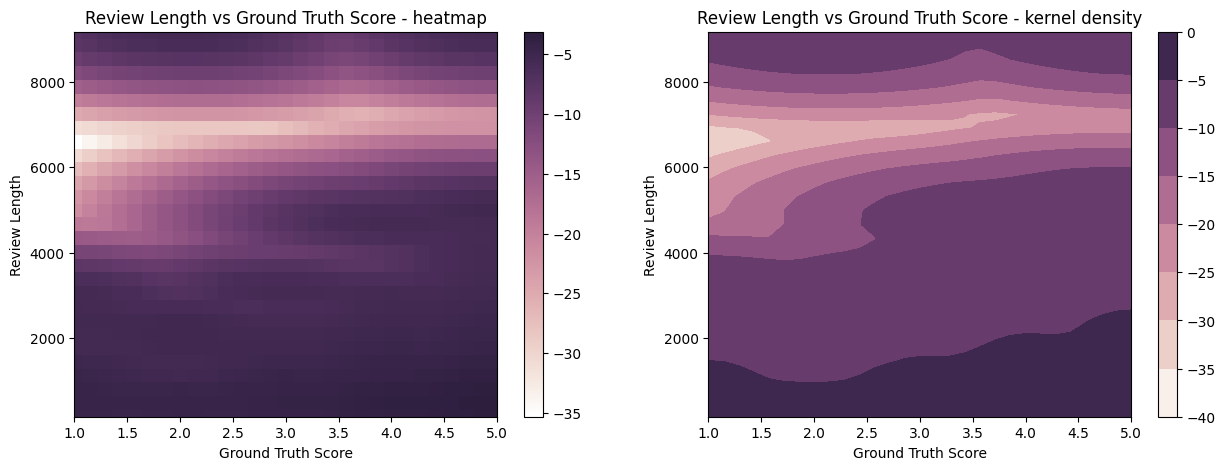

In [112]:
# Calculate the point density
k_c2a = gaussian_kde(np.vstack([rating_scores, review_length]))
xi_c2a, yi_c2a = np.mgrid[rating_scores.min():rating_scores.max():rating_scores.size**0.5*1j,review_length.min():review_length.max():review_length.size**0.5*1j]
zi_c2a = k_c2a(np.vstack([xi_c2a.flatten(), yi_c2a.flatten()]))

# Creating the heatmap
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(15, 5))
b1_c2a = ax1.pcolormesh(xi_c2a, yi_c2a, np.log10(zi_c2a.reshape(xi_c2a.shape)), cmap=cmap)
b2_c2a = ax2.contourf(xi_c2a, yi_c2a, np.log10(zi_c2a.reshape(xi_c2a.shape)), cmap=cmap)
ax1.set_xlim(rating_scores.min(), rating_scores.max())
ax1.set_ylim(review_length.min(), review_length.max())
ax2.set_xlim(rating_scores.min(), rating_scores.max())
ax2.set_ylim(review_length.min(), review_length.max())
ax1.set_xlabel("Ground Truth Score")
ax1.set_ylabel("Review Length")
ax2.set_xlabel("Ground Truth Score")
ax2.set_ylabel("Review Length")
fig.colorbar(b1_c2a, ax=ax1)
fig.colorbar(b2_c2a, ax=ax2)
ax1.set_title("Review Length vs Ground Truth Score - heatmap")
ax2.set_title("Review Length vs Ground Truth Score - kernel density");

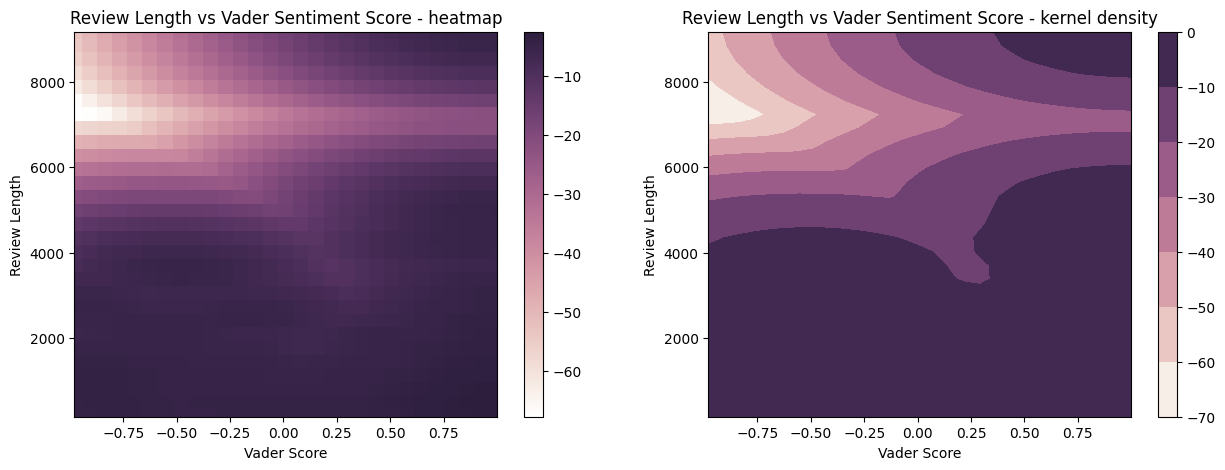

In [113]:
# Calculate the point density
k_c2b = gaussian_kde(np.vstack([vader_scores, review_length]))
xi_c2b, yi_c2b = np.mgrid[vader_scores.min():vader_scores.max():vader_scores.size**0.5*1j,review_length.min():review_length.max():review_length.size**0.5*1j]
zi_c2b = k_c2b(np.vstack([xi_c2b.flatten(), yi_c2b.flatten()]))

# Creating the heatmap
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(15, 5))
b1_c2b = ax1.pcolormesh(xi_c2b, yi_c2b, np.log10(zi_c2b.reshape(xi_c2b.shape)), cmap=cmap)
b2_c2b = ax2.contourf(xi_c2b, yi_c2b, np.log10(zi_c2b.reshape(xi_c2b.shape)), cmap=cmap)
ax1.set_xlim(vader_scores.min(), vader_scores.max())
ax1.set_ylim(review_length.min(), review_length.max())
ax2.set_xlim(vader_scores.min(), vader_scores.max())
ax2.set_ylim(review_length.min(), review_length.max())
ax1.set_xlabel("Vader Score")
ax1.set_ylabel("Review Length")
ax2.set_xlabel("Vader Score")
ax2.set_ylabel("Review Length")
fig.colorbar(b1_c2b, ax=ax1)
fig.colorbar(b2_c2b, ax=ax2)
ax1.set_title("Review Length vs Vader Sentiment Score - heatmap")
ax2.set_title("Review Length vs Vader Sentiment Score - kernel density");

From the outputs above, firstly, the scatterplots show a concentration of points at higher ground truth scores and Vader sentiment scores, which suggests that shorter reviews tend to have a more positive sentiment. This could indicate that customers who are satisfied with their experience may leave brief, positive feedback. Conversely, the lower density of points at lower scores and longer review lengths might reflect that more negative experiences are often accompanied by longer, more detailed explanations of the issues encountered. And then, the heatmaps, particularly the kernel density plots, reveal hotspots of high density around the higher scores, reinforcing the idea that positive reviews are not only more frequent but also tend to be shorter. The heatmaps also show less density in the areas corresponding to longer reviews and lower scores, suggesting these are less common. This might imply that while negative experiences are expressed in more detail, they are less frequently encountered or reported in the dataset.

In [114]:
# Extract the value
num_reviews = reviews_per_hotel.values
average_rs = np.sort(avg_rating_scores["ratingScore"].values)[::-1]
average_vader = np.sort(avg_vader_scores["vader"].values)[::-1]

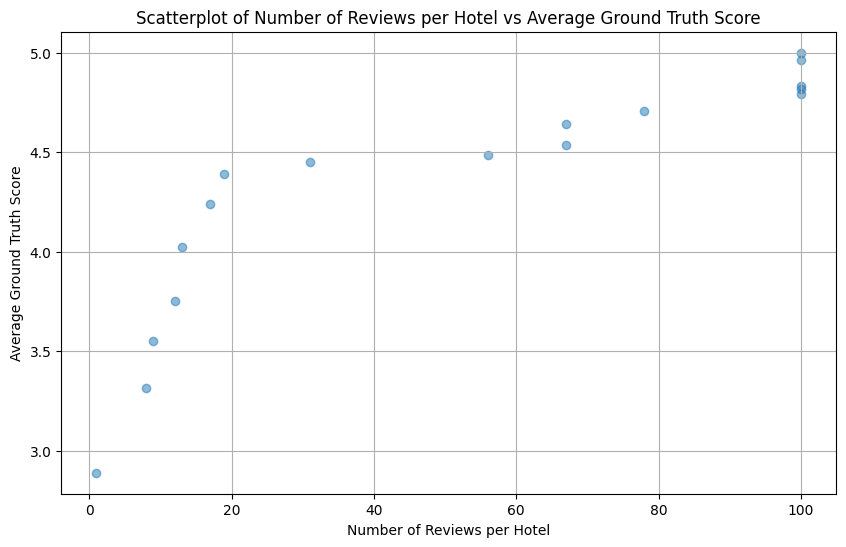

In [115]:
# Create scatterplots for Average Ground Truth Score vs Number of Reviews per Hotel
plt.figure(figsize=(10, 6))
plt.scatter(num_reviews, average_rs, alpha=0.5)
plt.title("Scatterplot of Number of Reviews per Hotel vs Average Ground Truth Score")
plt.xlabel("Number of Reviews per Hotel")
plt.ylabel("Average Ground Truth Score")
plt.grid(True)
plt.show()

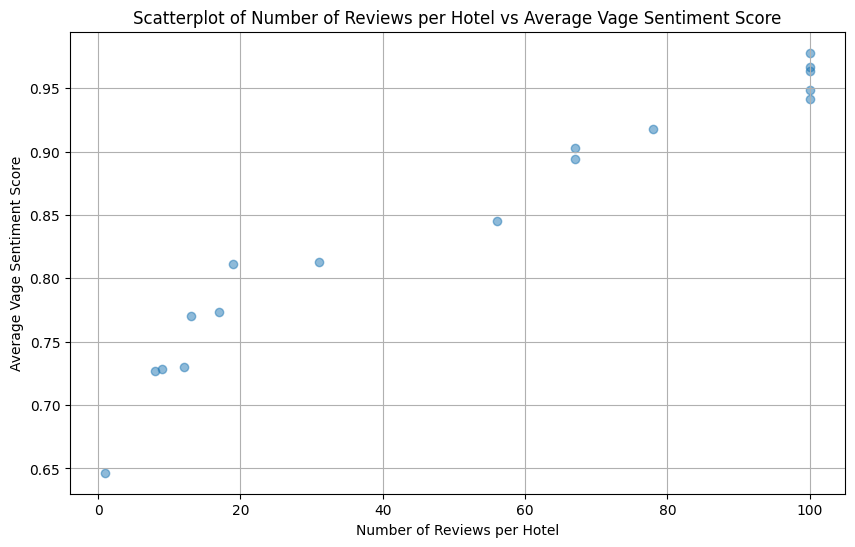

In [116]:
# Create scatterplots for Average Vage Sentiment Score vs Number of Reviews per Hotel
plt.figure(figsize=(10, 6))
plt.scatter(num_reviews, average_vader, alpha=0.5)
plt.title("Scatterplot of Number of Reviews per Hotel vs Average Vage Sentiment Score")
plt.xlabel("Number of Reviews per Hotel")
plt.ylabel("Average Vage Sentiment Score")
plt.grid(True)
plt.show()

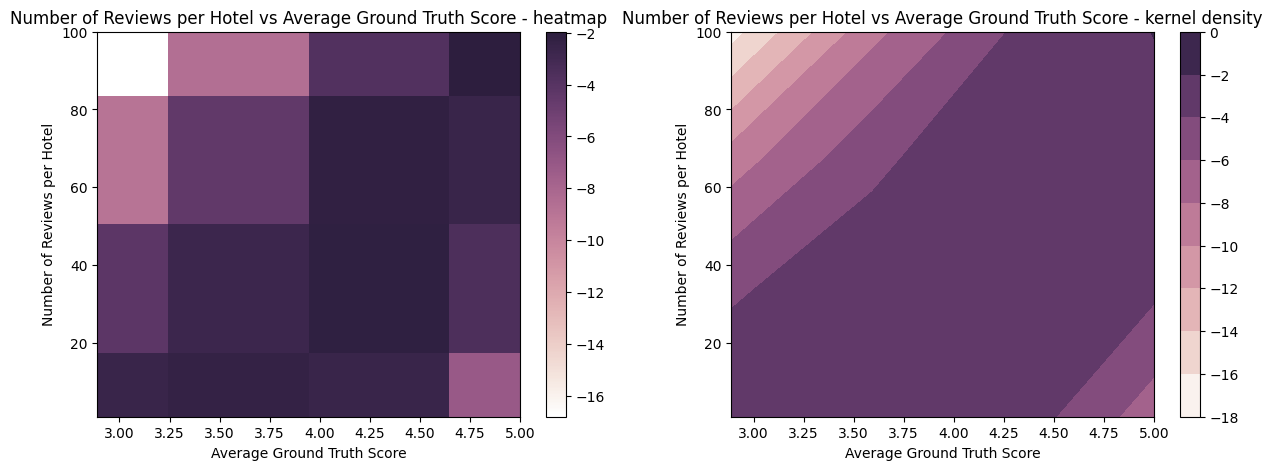

In [117]:
# Calculate the point density
k_c3a = gaussian_kde(np.vstack([average_rs, num_reviews]))
xi_c3a, yi_c3a = np.mgrid[average_rs.min():average_rs.max():average_rs.size**0.5*1j,num_reviews.min():num_reviews.max():num_reviews.size**0.5*1j]
zi_c3a = k_c3a(np.vstack([xi_c3a.flatten(), yi_c3a.flatten()]))

# Creating the heatmap
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(15, 5))
b1_c3a = ax1.pcolormesh(xi_c3a, yi_c3a, np.log10(zi_c3a.reshape(xi_c3a.shape)), cmap=cmap)
b2_c3a = ax2.contourf(xi_c3a, yi_c3a, np.log10(zi_c3a.reshape(xi_c3a.shape)), cmap=cmap)
ax1.set_xlim(average_rs.min(), average_rs.max())
ax1.set_ylim(num_reviews.min(), num_reviews.max())
ax2.set_xlim(average_rs.min(), average_rs.max())
ax2.set_ylim(num_reviews.min(), num_reviews.max())
ax1.set_xlabel("Average Ground Truth Score")
ax1.set_ylabel("Number of Reviews per Hotel")
ax2.set_xlabel("Average Ground Truth Score")
ax2.set_ylabel("Number of Reviews per Hotel")
fig.colorbar(b1_c3a, ax=ax1)
fig.colorbar(b2_c3a, ax=ax2)
ax1.set_title("Number of Reviews per Hotel vs Average Ground Truth Score - heatmap")
ax2.set_title("Number of Reviews per Hotel vs Average Ground Truth Score - kernel density");

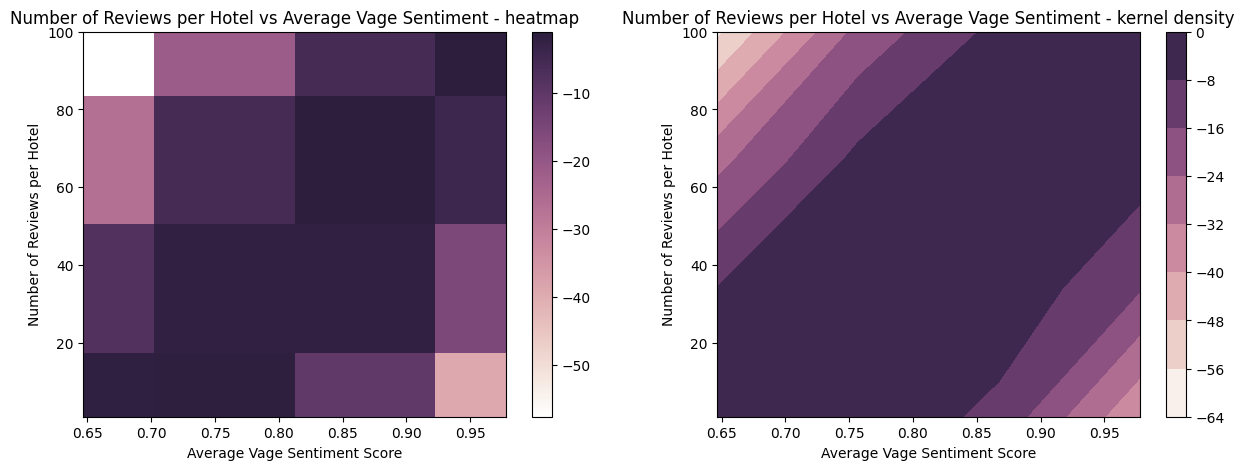

In [118]:
# Calculate the point density
k_c3b = gaussian_kde(np.vstack([average_vader, num_reviews]))
xi_c3b, yi_c3b = np.mgrid[average_vader.min():average_vader.max():average_vader.size**0.5*1j,num_reviews.min():num_reviews.max():num_reviews.size**0.5*1j]
zi_c3b = k_c3b(np.vstack([xi_c3b.flatten(), yi_c3b.flatten()]))

# Creating the heatmap
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(15, 5))
b1_c3b = ax1.pcolormesh(xi_c3b, yi_c3b, np.log10(zi_c3b.reshape(xi_c3b.shape)), cmap=cmap)
b2_c3b = ax2.contourf(xi_c3b, yi_c3b, np.log10(zi_c3b.reshape(xi_c3b.shape)), cmap=cmap)
ax1.set_xlim(average_vader.min(), average_vader.max())
ax1.set_ylim(num_reviews.min(), num_reviews.max())
ax2.set_xlim(average_vader.min(), average_vader.max())
ax2.set_ylim(num_reviews.min(), num_reviews.max())
ax1.set_xlabel("Average Vage Sentiment Score")
ax1.set_ylabel("Number of Reviews per Hotel")
ax2.set_xlabel("Average Vage Sentiment Score")
ax2.set_ylabel("Number of Reviews per Hotel")
fig.colorbar(b1_c3b, ax=ax1)
fig.colorbar(b2_c3b, ax=ax2)
ax1.set_title("Number of Reviews per Hotel vs Average Vage Sentiment - heatmap")
ax2.set_title("Number of Reviews per Hotel vs Average Vage Sentiment - kernel density");

From the output above, firstly, for the ground truth score, hotels with higher review counts tend to have higher scores, indicating that well-reviewed hotels may not only have quality service but also a higher number of guests willing to leave positive feedback. The Vader sentiment scatterplot shows less clear correlation between review counts and sentiment scores, suggesting that Vader sentiment analysis may be less consistent than ground truth scores in reflecting customer satisfaction in this dataset. Secondly, the heatmap for ground truth scores shows a concentration of higher scores with increased review counts, reinforcing the trend observed in the scatterplot. In contrast, the heatmap for Vader sentiment scores does not exhibit a strong correlation between review counts and sentiment scores. This suggests that while hotels may receive a large number of reviews, these do not consistently translate to uniformly high Vader sentiment scores.

In [119]:
def make_address(row):
  # individual columns need to be combined
  return row['streetAddress']+", "+row['City']+", "+row['Province']

In [120]:
# Need the location for each hotel in a format the tool can handle

geo_rating_df = avg_rating_scores\
                         .join(hotelDf.groupby('hotelName')\
                         .agg({'streetAddress':'max','City':'max','Province':'max','postalCode':'max'}))

In [121]:
address_updates = {
    "Blue Spruce Resort": ["1215 Oxtongue Lake Rd", "Dwight", "Ontario", "P0A 1H0"],
    "Christie&#39;s Mill Inn and Spa": ["263 Port Severn Rd N", "Port Severn", "Ontario", "L0K 1S0"],
    "Dwight Village Motel": ["2801 ON-60", "Dwight", "Ontario", "P0A 1H0"],
    "Fern Glen Inn B&amp;B": ["1462 Fern Glen Rd", "Emsdale", "Ontario", "P0A 1J0"],
    "Heidi&#39;s Campground": ["3982 ON-11", "Hawkestone", "Ontario", "L0L 1T0"],
    "Lakewoods Cottage Resort": ["1109 Oxtongue Lake Rd", "Dwight", "Ontario", "P0A 1H0"],
    "Logging Chain Lodge": ["2840 ON-60", "Dwight", "Ontario", "P0A 1H0"],
    "Loralea Country Inn Resort": ["17560 ON-35", "Algonquin Highlands", "Ontario", "K0M 1J2"],
    "Muskoka Waterfront Retreat": ["1091 Dwight Beach Rd", "Dwight", "Ontario", "P0A 1H0"],
    "Rawley Resort": ["2900 Kellys Rd", "Port Severn", "Ontario", "L0K 1S0"],
    "Severn Lodge": ["116 Gloucester Trail", "Port Severn", "Ontario", "L0K 1S0"],
    "Silver Eagle Cottages": ["1127 Sir Sam Evans Rd", "Eagle Lake", "Ontario", "K0M 1M0"],
    "Sir Sam&#39;s Inn &amp; Spa": ["1491 Sir Sams's Rd", "Eagle Lake", "Ontario", "K0M 1M0"],
    "Spring Lake Resort Motel and Restaurant": ["2893 ON-60", "Dwight", "Ontario", "P0A 1H0"],
    "Sun Retreats Georgian Bay": ["105 Blue Lake Rd", "Seguin", "Ontario", "P2A 0B2"],
    "Sunnylea Resort": ["117 Port Severn Rd", "Port Severn", "Ontario", "L0K 1S0"],
    "The Pines Cottage Resort": ["1032 Oxtongue Lake Rd", "Dwight", "Ontario", "P0A 1H0"]
}

# Replace the address information in the DataFrame:
for hotel, (address, city, province, postal_code) in address_updates.items():
    index = geo_rating_df[geo_rating_df["hotelName"] == hotel].index
    geo_rating_df.loc[index, "streetAddress"] = address
    geo_rating_df.loc[index, "City"] = city
    geo_rating_df.loc[index, "Province"] = province
    geo_rating_df.loc[index, "postalCode"] = postal_code

In [122]:
geo_rating_df["formed_address"] = geo_rating_df.apply(make_address , axis=1)
geo_rating_df

hotelName  ratingScore          streetAddress                 City Province postalCode                              formed_address
0                        Blue Spruce Resort     4.820000  1215 Oxtongue Lake Rd               Dwight  Ontario    P0A 1H0      1215 Oxtongue Lake Rd, Dwight, Ontario
1           Christie&#39;s Mill Inn and Spa     3.315789   263 Port Severn Rd N          Port Severn  Ontario    L0K 1S0  263 Port Severn Rd N, Port Severn, Ontario
2                      Dwight Village Motel     4.641791             2801 ON-60               Dwight  Ontario    P0A 1H0                 2801 ON-60, Dwight, Ontario
3                     Fern Glen Inn B&amp;B     4.964286      1462 Fern Glen Rd              Emsdale  Ontario    P0A 1J0         1462 Fern Glen Rd, Emsdale, Ontario
4                    Heidi&#39;s Campground     2.888889             3982 ON-11           Hawkestone  Ontario    L0L 1T0             3982 ON-11, Hawkestone, Ontario
5                  Lakewoods Cottage Resort     4.483871  1109 Oxtongue Lake Rd               Dwight  Ontario    P0A 1H0      1109 Oxtongue Lake Rd, Dwight, Ontario
6                       Logging Chain Lodge     4.833333             2840 ON-60               Dwight  Ontario    P0A 1H0                 2840 ON-60, Dwight, Ontario
7                Loralea Country Inn Resort     4.791045            17560 ON-35  Algonquin Highlands  Ontario    K0M 1J2   17560 ON-35, Algonquin Highlands, Ontario
8                Muskoka Waterfront Retreat     5.000000   1091 Dwight Beach Rd               Dwight  Ontario    P0A 1H0       1091 Dwight Beach Rd, Dwight, Ontario
9                             Rawley Resort     4.450000         2900 Kellys Rd          Port Severn  Ontario    L0K 1S0        2900 Kellys Rd, Port Severn, Ontario
10                             Severn Lodge     4.240000   116 Gloucester Trail          Port Severn  Ontario    L0K 1S0  116 Gloucester Trail, Port Severn, Ontario
11                    Silver Eagle Cottages     4.705882  1127 Sir Sam Evans Rd           Eagle Lake  Ontario    K0M 1M0  1127 Sir Sam Evans Rd, Eagle Lake, Ontario
12              Sir Sam&#39;s Inn &amp; Spa     3.550000     1491 Sir Sams's Rd           Eagle Lake  Ontario    K0M 1M0     1491 Sir Sams's Rd, Eagle Lake, Ontario
13  Spring Lake Resort Motel and Restaurant     4.390000             2893 ON-60               Dwight  Ontario    P0A 1H0                 2893 ON-60, Dwight, Ontario
14                Sun Retreats Georgian Bay     3.750000       105 Blue Lake Rd               Seguin  Ontario    P2A 0B2           105 Blue Lake Rd, Seguin, Ontario
15                          Sunnylea Resort     4.025641     117 Port Severn Rd          Port Severn  Ontario    L0K 1S0    117 Port Severn Rd, Port Severn, Ontario
16                 The Pines Cottage Resort     4.538462  1032 Oxtongue Lake Rd               Dwight  Ontario    P0A 1H0      1032 Oxtongue Lake Rd, Dwight, Ontario

In [123]:
# 0 - need to give the tool a generic name.
locator = Photon(user_agent="myGeocoder")
# 1 - conveneint function to delay between geocoding calls
geocode = RateLimiter(locator.geocode, min_delay_seconds=1)
# 2 - form the location string
geo_rating_df["location"] = geo_rating_df["formed_address"].apply(geocode)
# 3 - create longitude, laatitude and altitude from location column (returns tuple)
geo_rating_df["point"] = geo_rating_df["location"].apply(lambda loc: tuple(loc.point) if loc else None)
# 4 - split point column into latitude, longitude and altitude columns
geo_rating_df[["latitude", "longitude", "altitude"]] = pd.DataFrame(geo_rating_df["point"].tolist(), index=geo_rating_df.index)

In [124]:
geo_rating_df_cleaned = geo_rating_df.dropna()
geo_rating_df_cleaned

hotelName  ratingScore          streetAddress                 City Province postalCode                              formed_address                                                                                                                                location                                          point   latitude  longitude  altitude
0                        Blue Spruce Resort     4.820000  1215 Oxtongue Lake Rd               Dwight  Ontario    P0A 1H0      1215 Oxtongue Lake Rd, Dwight, Ontario  (1215, Oxtongue Lake Road, P0A 1H0, Oxtongue Lake Road, Algonquin Highlands, Ontario, Canada, (45.378055148246844, -78.9246654733724))   (45.378055148246844, -78.9246654733724, 0.0)  45.378055 -78.924665       0.0
1           Christie&#39;s Mill Inn and Spa     3.315789   263 Port Severn Rd N          Port Severn  Ontario    L0K 1S0  263 Port Severn Rd N, Port Severn, Ontario                                           (263, Náchodská, 54932, Náchodská, Velké Poříčí, Severovýchod, Česko, (50.46293, 16.1841224))                    (50.46293, 16.1841224, 0.0)  50.462930  16.184122       0.0
2                      Dwight Village Motel     4.641791             2801 ON-60               Dwight  Ontario    P0A 1H0                 2801 ON-60, Dwight, Ontario                         (60, Dwight Avenue, M8V 2X4, Dwight Avenue, Toronto, Ontario, Canada, (43.604612092592596, -79.49876751851852))  (43.604612092592596, -79.49876751851852, 0.0)  43.604612 -79.498768       0.0
4                    Heidi&#39;s Campground     2.888889             3982 ON-11           Hawkestone  Ontario    L0L 1T0             3982 ON-11, Hawkestone, Ontario                         (3982, Highway 11, L0L 1T0, Highway 11, Oro-Medonte, Ontario, Canada, (44.503716778947364, -79.48287866578947))  (44.503716778947364, -79.48287866578947, 0.0)  44.503717 -79.482879       0.0
5                  Lakewoods Cottage Resort     4.483871  1109 Oxtongue Lake Rd               Dwight  Ontario    P0A 1H0      1109 Oxtongue Lake Rd, Dwight, Ontario      (1109, Windy Point Road, P0A 1H0, Windy Point Road, Algonquin Highlands, Ontario, Canada, (45.37296231922831, -78.91114620868898))   (45.37296231922831, -78.91114620868898, 0.0)  45.372962 -78.911146       0.0
6                       Logging Chain Lodge     4.833333             2840 ON-60               Dwight  Ontario    P0A 1H0                 2840 ON-60, Dwight, Ontario                                  (2840, Highway 60, Highway 60, Lake of Bays, Ontario, Canada, (45.32257792471264, -78.98151792308552))   (45.32257792471264, -78.98151792308552, 0.0)  45.322578 -78.981518       0.0
7                Loralea Country Inn Resort     4.791045            17560 ON-35  Algonquin Highlands  Ontario    K0M 1J2   17560 ON-35, Algonquin Highlands, Ontario                                                         (Algonquin Highlands, Ontario, Canada, (45.294673450000005, -78.8255514671391))   (45.294673450000005, -78.8255514671391, 0.0)  45.294673 -78.825551       0.0
8                Muskoka Waterfront Retreat     5.000000   1091 Dwight Beach Rd               Dwight  Ontario    P0A 1H0       1091 Dwight Beach Rd, Dwight, Ontario                                                           (Dwight Beach Road, Lake of Bays, Ontario, Canada, (45.3298402, -79.0166185))                 (45.3298402, -79.0166185, 0.0)  45.329840 -79.016619       0.0
9                             Rawley Resort     4.450000         2900 Kellys Rd          Port Severn  Ontario    L0K 1S0        2900 Kellys Rd, Port Severn, Ontario                             (2900, Kellys Road, L0K 1S0, Kellys Road, Severn, Ontario, Canada, (44.80580044954644, -79.71721676842003))   (44.80580044954644, -79.71721676842003, 0.0)  44.805800 -79.717217       0.0
10                             Severn Lodge     4.240000   116 Gloucester Trail          Port Severn  Ontario    L0K 1S0  116 Gloucester Trail, Port Severn, Ontario                       (116, Galinee Trail, N0A 1N5, Galinee Trail, Po

In [125]:
map1 = folium.Map(
    location=[43.0896,-79.0849], # <- this will need to be set based on your own hotels
    tiles='cartodbpositron',
    zoom_start=12,
)

geo_rating_df_cleaned.dropna().apply(lambda row:folium.CircleMarker(location=[row["latitude"], row["longitude"]], color='#d7191c').add_to(map1), axis=1)

map1

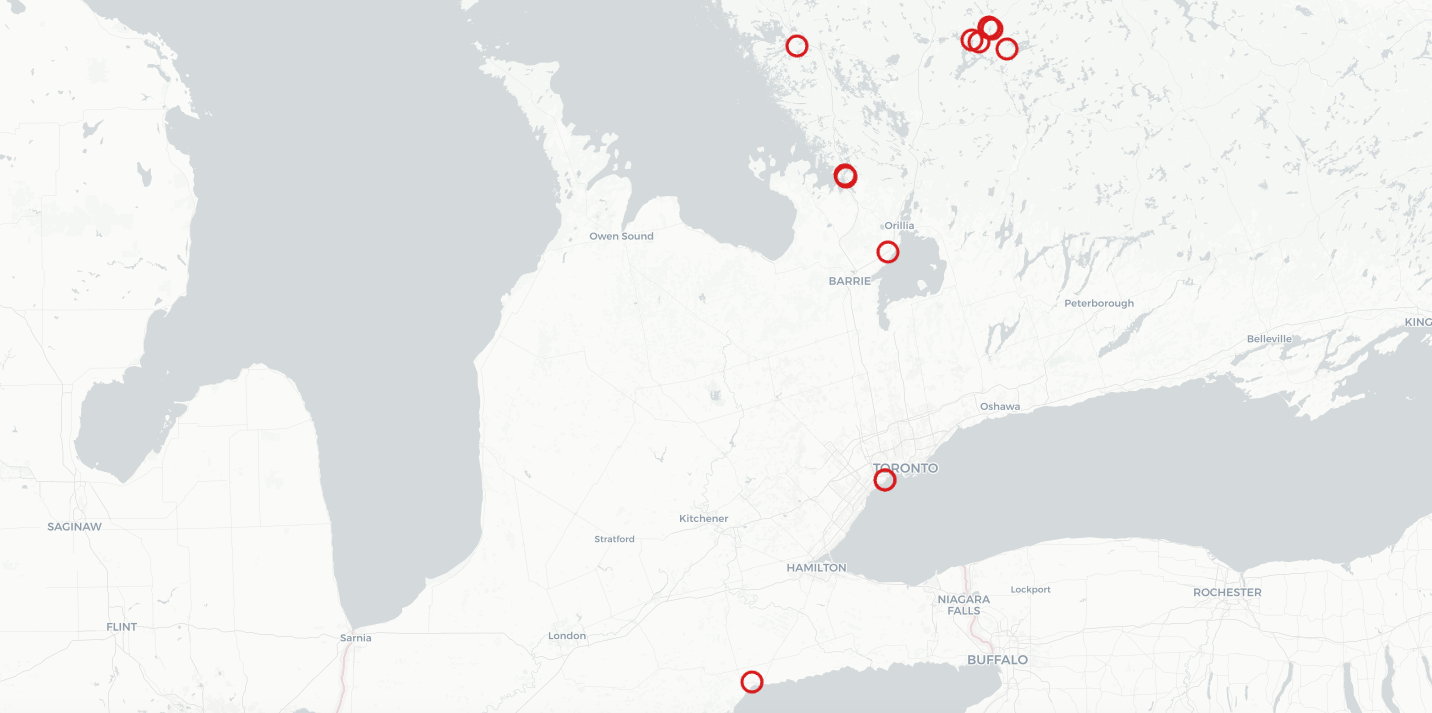

In [126]:
from IPython.display import Image

Image("generate_output.png")

From the output above, I think that there does not appear much a visible relation between location and reviews because the location that has many hotels may also have both hotels with positive reviews and hotels with negative reviews. Yes, I think that I recommend people to stay near the city of Dwight because many hotels can be chosen although it may exist some of them with negative reviews.

In [127]:
six_hotels = ["Muskoka Waterfront Retreat", "Logging Chain Lodge", "Heidi&#39;s Campground",
              "Sun Retreats Georgian Bay", "Rawley Resort", "Severn Lodge"]

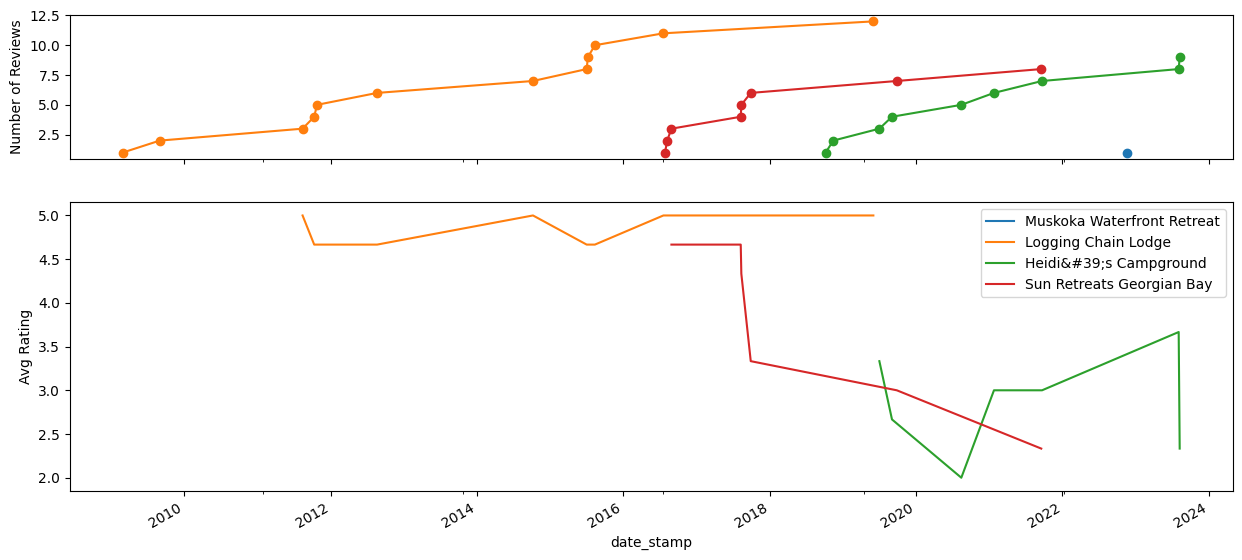

In [128]:
# It can be useful to see when reviews were being made and how the ratings changed using a running mean
fig, ax = plt.subplots(2, 1, figsize=(15,7),
                       sharex=True,
                       gridspec_kw={
                           'height_ratios': [1, 2]})

for hotel in six_hotels[:4]:
  _df = cleaned_hotelDf[cleaned_hotelDf['hotelName']==hotel].set_index('date_stamp')
  _df.index = pd.to_datetime(_df.index)
  _df = _df.sort_index()
  _df['count'] = 1
  _df['count'].cumsum().plot(ax=ax[0],label=hotel, marker='o')
  _df['ratingScore'].rolling(3).mean().plot(ax=ax[1],label=hotel)

ax[1].set_ylabel('Avg Rating')
ax[0].set_ylabel('Number of Reviews')
plt.legend()

From the output above, we can see that the rating scores for highly-rated hotels like "Logging Chain Lodge" are nearly consistent as time passes, and the rating scores for lowly-rated hotels like "Heidi&#39;s Campground" fluctuate as time passes. It means that the rating score for highly rated hotels may stay nearly stable over time and the rating score lowly rated hotels may experience fluctuation as time changes.

/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:1400: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)
/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:1400: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)


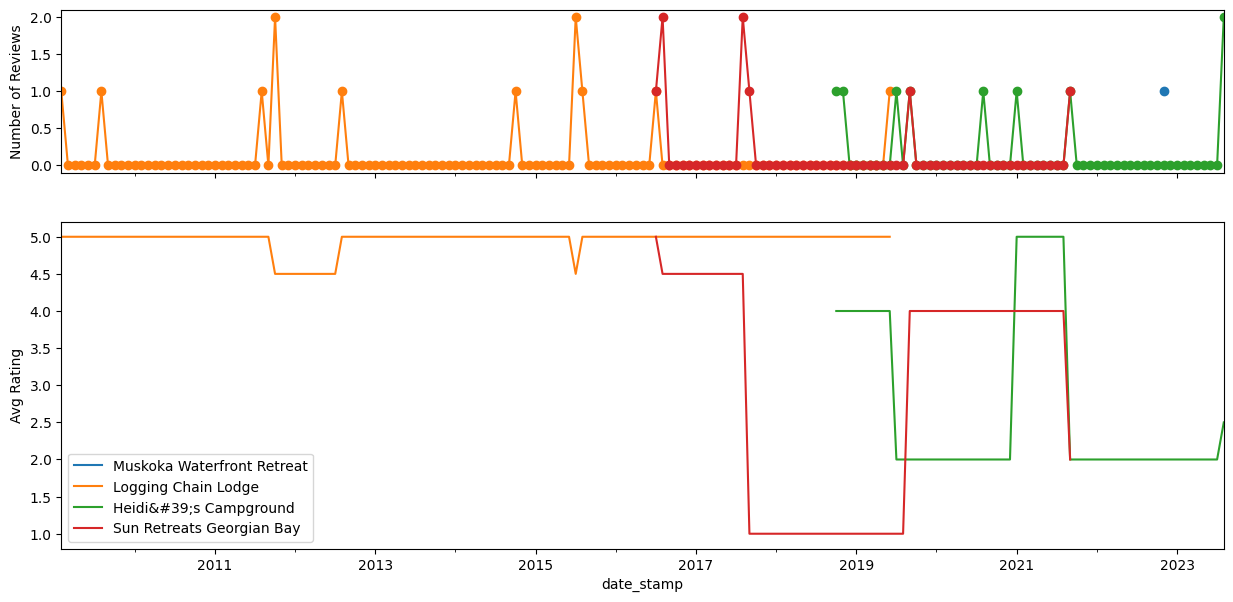

In [129]:
fig, ax = plt.subplots(2, 1, figsize=(15,7),
                       sharex=True,
                       gridspec_kw={
                           'height_ratios': [1, 2]})

for hotel in six_hotels[:4]:
  _df = hotelDf[hotelDf['hotelName']==hotel].set_index('date_stamp')
  _df.index = pd.to_datetime(_df.index)
  _df = _df.sort_index()
  _df['count'] = 1
  _df_monthly = _df.groupby(pd.Grouper(freq='M')).agg({'count':'sum','ratingScore':'mean'})
  _df_monthly['ratingScore'] = _df_monthly['ratingScore'].fillna(method='ffill')
  _df_monthly['count'].plot(ax=ax[0],label=hotel, marker='o')
  _df_monthly['ratingScore'].plot(ax=ax[1],label=hotel)

ax[1].set_ylabel('Avg Rating')
ax[0].set_ylabel('Number of Reviews')
plt.legend()

From the output above, we can see that the rate of reviews for highly-rated hotels like "Logging Chain Lodge" is nearly consistent as time passes, and the rate of reviews for lowly-rated hotels like "Heidi&#39;s Campground" fluctuates as time passes. Therefore, based on this observation, I predict that the rate of reviews for highly rated hotels may stay nearly stable over time and the rate of reviews for lowly rated hotels may experience fluctuation as time changes.